# Suicide Rate Prediction

#### Importing Necessary Modules

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from category_encoders import OrdinalEncoder,OneHotEncoder,TargetEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score

#Models
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor

#### Importing Dataset

In [2]:
df = pd.read_csv('suicide_rate.csv')
df

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year($),gdp_per_capita($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


#### Checking the size of the dataset

In [3]:
print("The size of the following dataset is:",df.shape)

The size of the following dataset is: (27820, 12)


#### Dropping country-year column as it seems irrelevant

In [4]:
df.drop('country-year',axis = 1, inplace = True)
df

,country,year,sex,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year($),gdp_per_capita($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,0.675,"63,067,077,179",2309,Generation Z


#### Checking the information of the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            27820 non-null  object 
 1   year               27820 non-null  int64  
 2   sex                27820 non-null  object 
 3   age                27820 non-null  object 
 4   suicides_no        27820 non-null  int64  
 5   population         27820 non-null  int64  
 6   suicides/100k pop  27820 non-null  float64
 7   HDI for year       8364 non-null   float64
 8   gdp_for_year($)    27820 non-null  object 
 9   gdp_per_capita($)  27820 non-null  int64  
 10  generation         27820 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 2.3+ MB


#### Checking the statistical information of the dataset

In [6]:
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


#### Checking the Null values present in the dataset

In [7]:
df.isnull().sum()

country                  0
year                     0
sex                      0
age                      0
suicides_no              0
population               0
suicides/100k pop        0
HDI for year         19456
gdp_for_year($)          0
gdp_per_capita($)        0
generation               0
dtype: int64

#### Showing the null values in a heatmap

Text(0.5, 1.0, 'Missing Values in Heatmap')

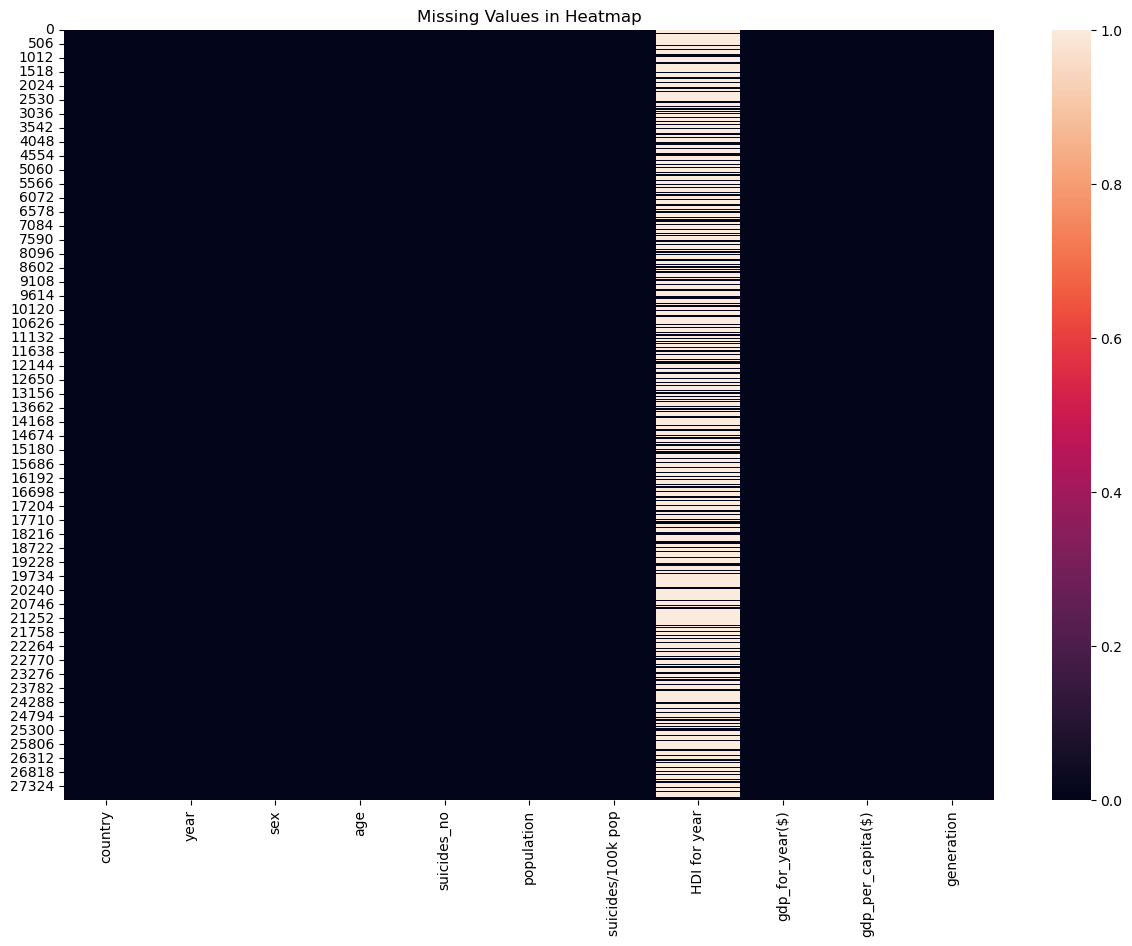

In [8]:
plt.figure(figsize = (15,10))
sns.heatmap(df.isnull())
plt.title("Missing Values in Heatmap")

#### Here we can see HDI for year contains most of the null values, hence dropping the following column from the dataset

In [9]:
df.drop("HDI for year",axis = 1, inplace = True)
df

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_for_year($),gdp_per_capita($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,"63,067,077,179",2309,Generation Z


#### Now checking for Null values again in Heatmap

Text(0.5, 1.0, 'Missing Values in Heatmap')

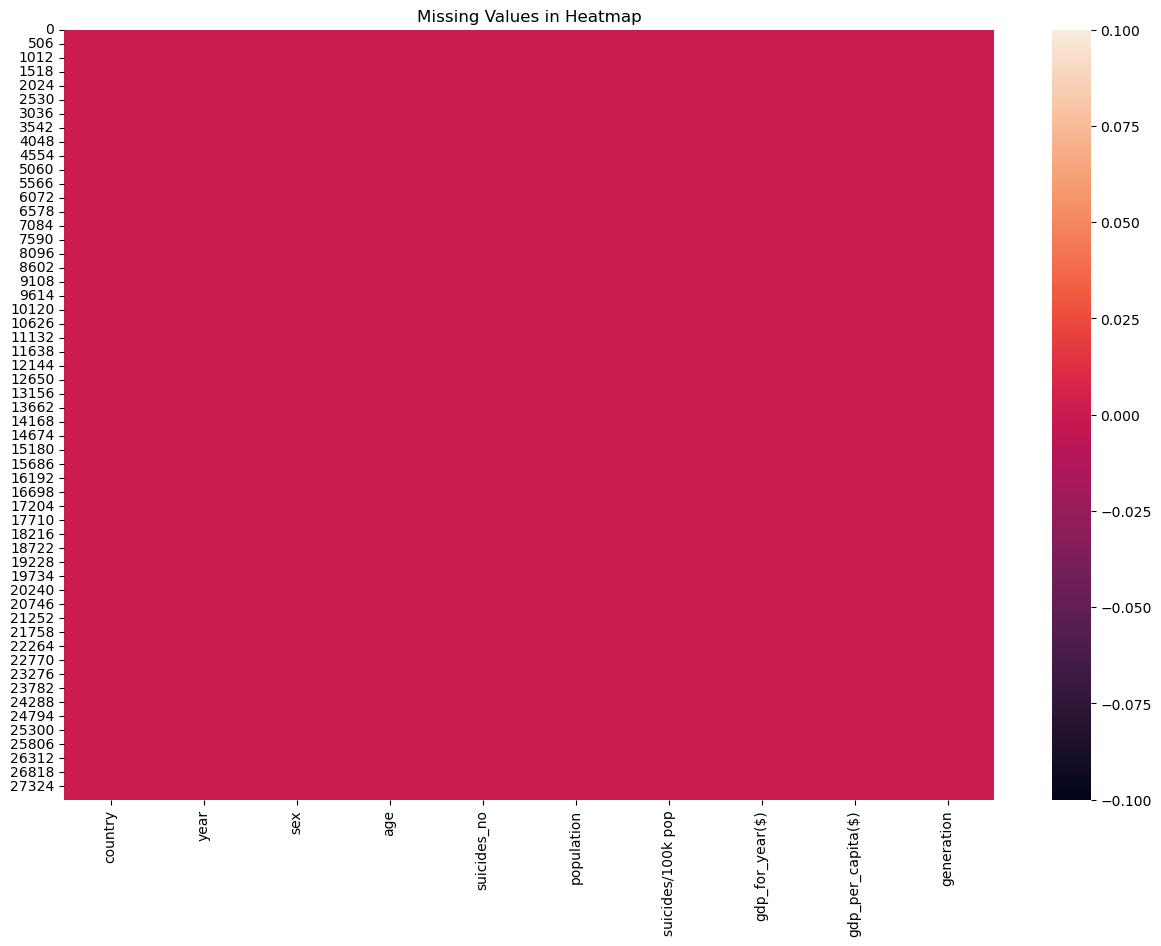

In [10]:
plt.figure(figsize = (15,10))
sns.heatmap(df.isnull())
plt.title("Missing Values in Heatmap")

#### Now we can see there is no null value present in the dataset anymore

#### Now we need to modify gdp_for_year as it contains special character and make it integer column

In [11]:
# Define a lambda function to replace ","
replacer = lambda x: x.replace(",","")

# Applying it to the dataframe
df["""gdp_for_year($)"""] = df["""gdp_for_year($)"""].apply(replacer)

# Conver the column to Numeric type
df["""gdp_for_year($)"""] = pd.to_numeric(df["""gdp_for_year($)"""])
df

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_for_year($),gdp_per_capita($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,2156624900,796,Boomers
...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,63067077179,2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,63067077179,2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,63067077179,2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,63067077179,2309,Generation Z


#### Checking whether its converted to Numeric or not

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            27820 non-null  object 
 1   year               27820 non-null  int64  
 2   sex                27820 non-null  object 
 3   age                27820 non-null  object 
 4   suicides_no        27820 non-null  int64  
 5   population         27820 non-null  int64  
 6   suicides/100k pop  27820 non-null  float64
 7   gdp_for_year($)    27820 non-null  int64  
 8   gdp_per_capita($)  27820 non-null  int64  
 9   generation         27820 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 2.1+ MB


### Checking for Duplicate rows

In [13]:
df.duplicated().sum()

0

### Exploratory Data Analysis

#### Checking the correlation among the attributes

C:\Users\arghy\AppData\Local\Temp\ipykernel_112\67435088.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot = True)


Text(0.5, 1.0, 'Correlation in Heatmap')

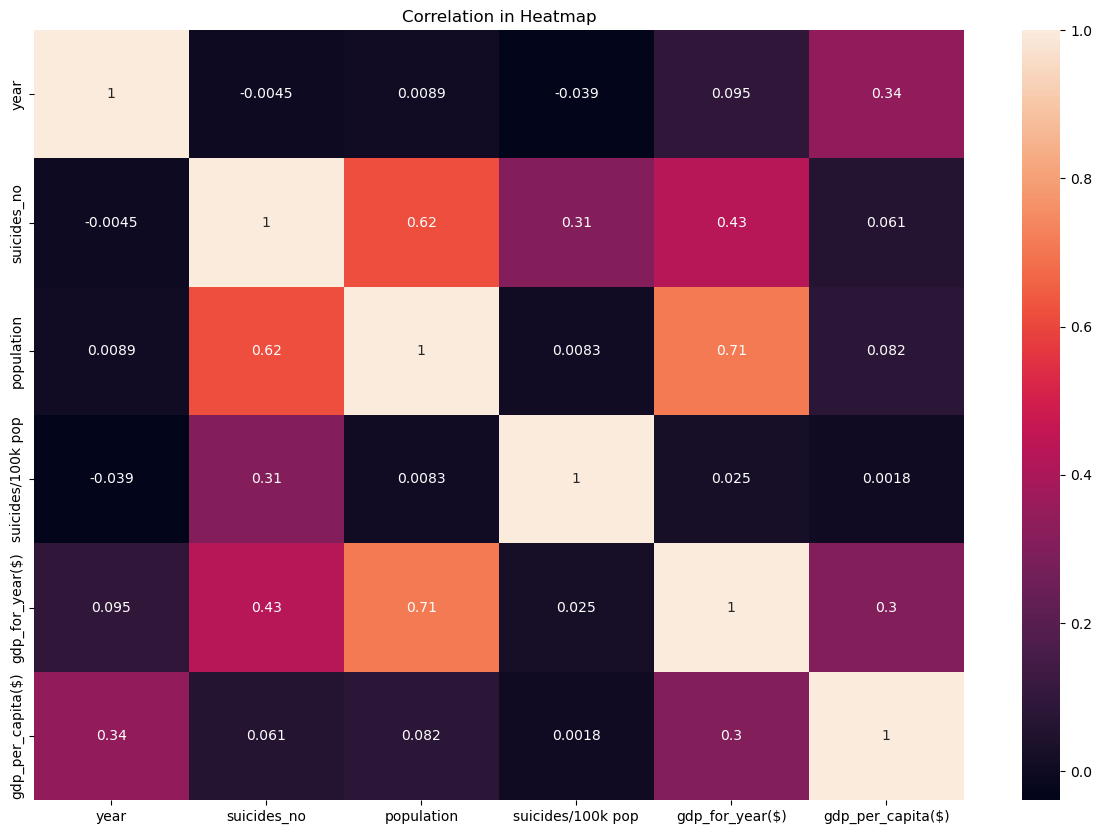

In [14]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(),annot = True)
plt.title("Correlation in Heatmap")

#### Showing correlation in Pairplot

Text(0.5, 1.0, 'Correlation in Pairplot')

<Figure size 1500x1000 with 0 Axes>

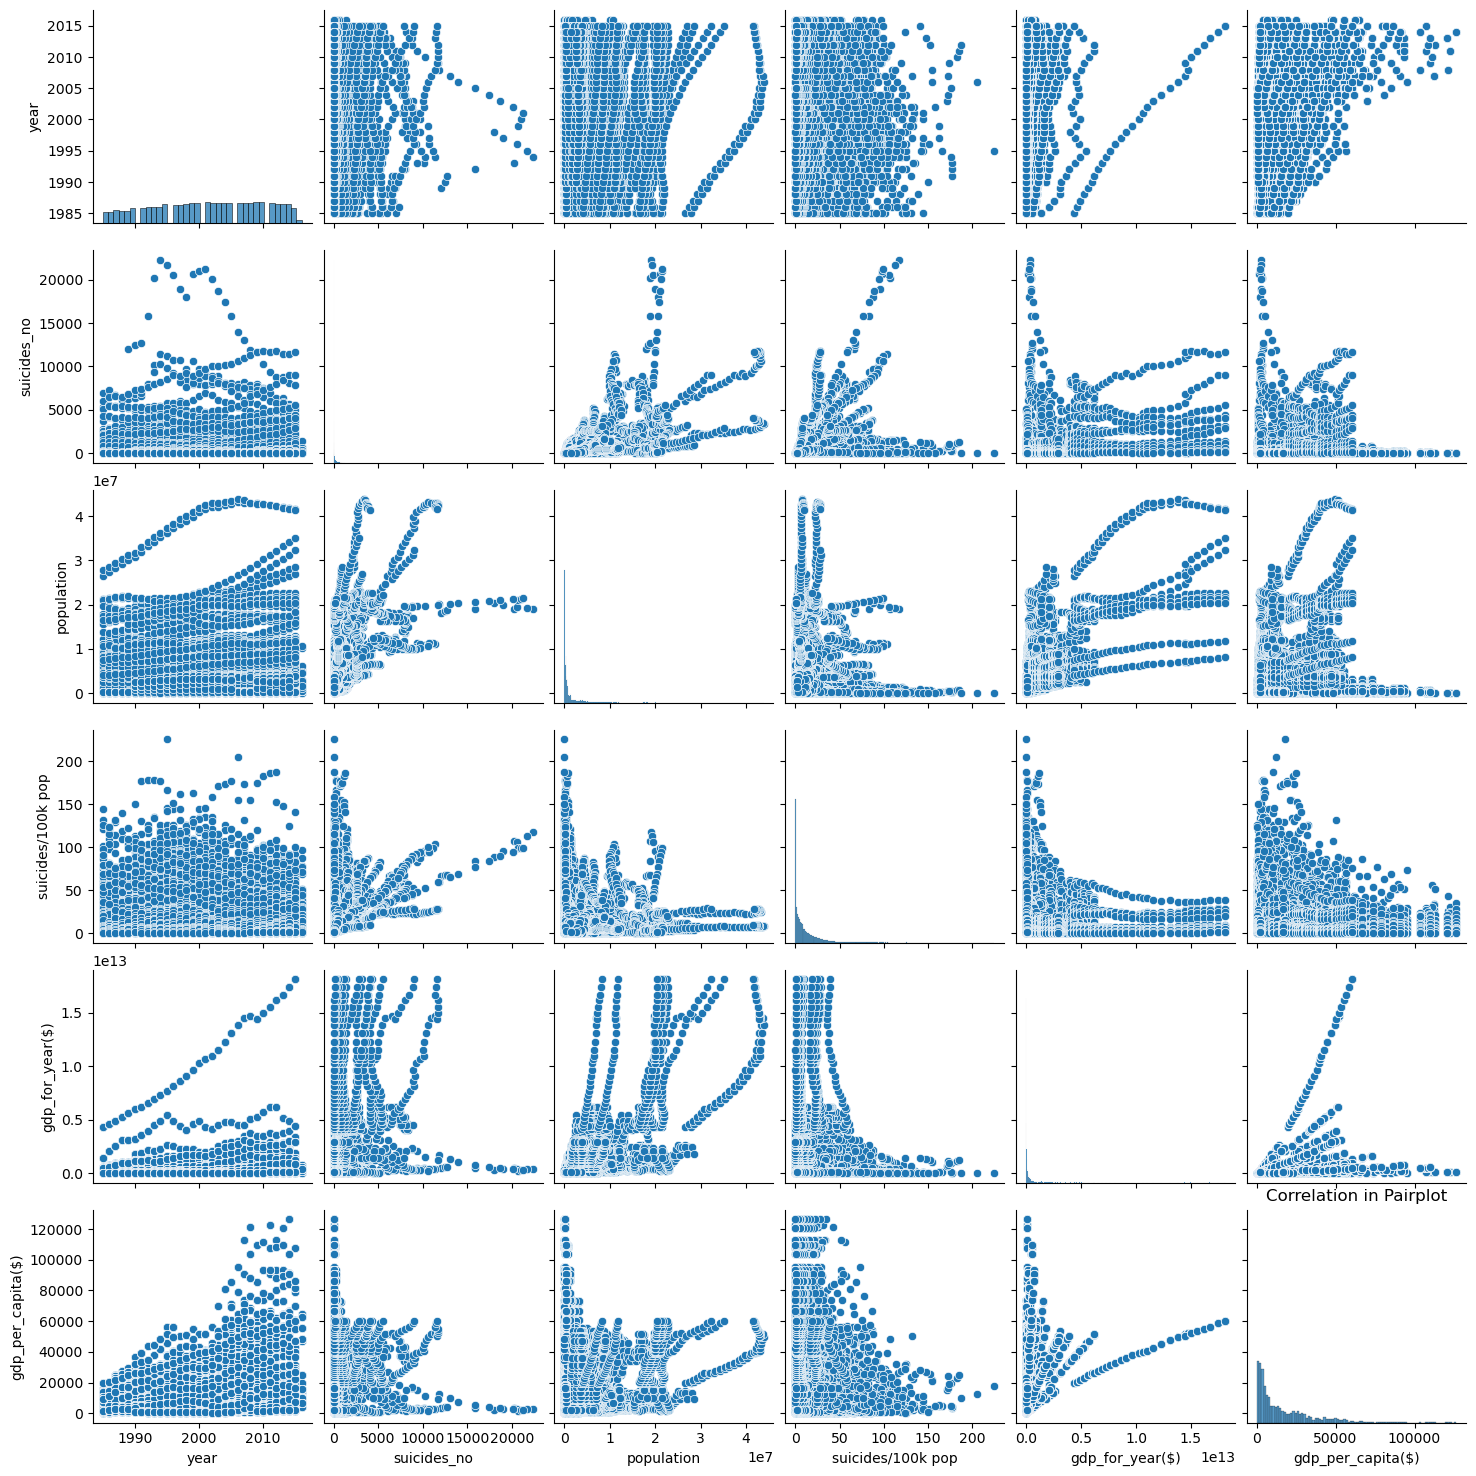

In [15]:
plt.figure(figsize = (15,10))
sns.pairplot(df)
plt.title("Correlation in Pairplot")

### Univariate Analysis

### Univariate Analysis for Numerical Attributes

In [16]:
## df.hist(figsize = (12,9),bins = 14)

Text(0.5, 1.0, 'Distribution of Suicide No')

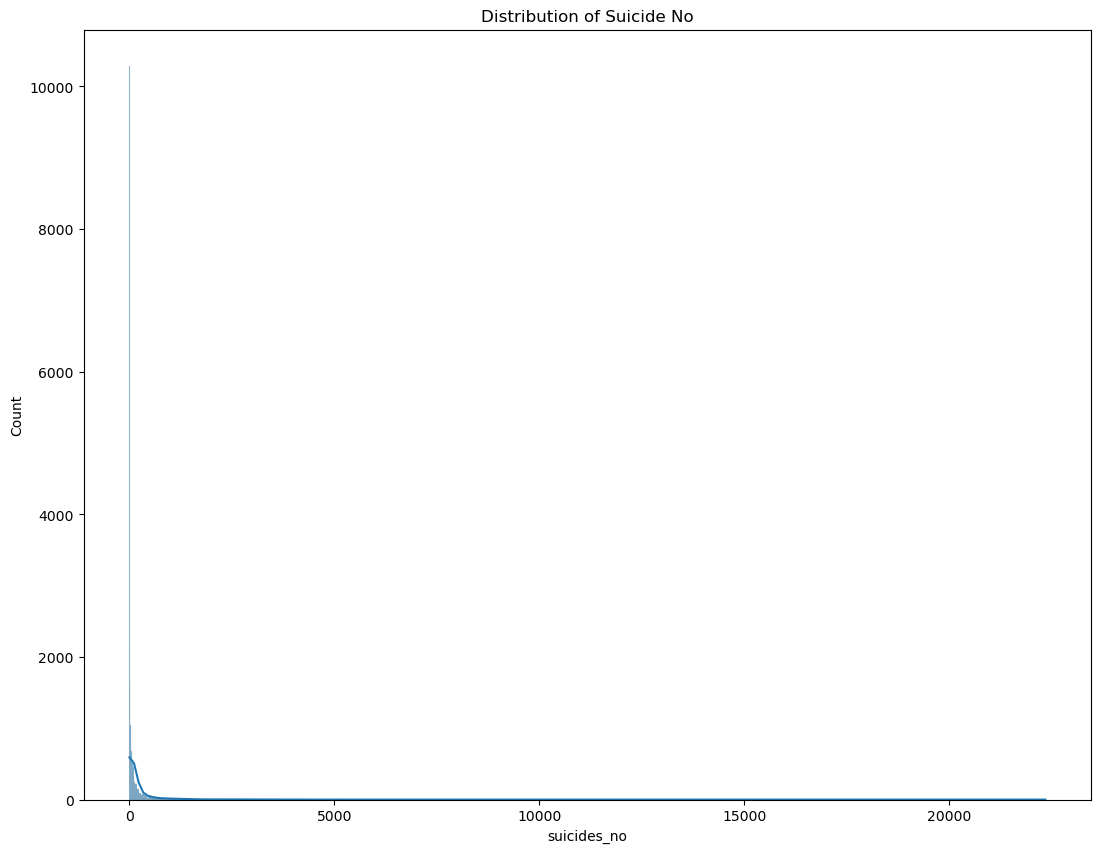

In [17]:
plt.figure(figsize = (13,10))
sns.histplot(df['suicides_no'], kde = True)
plt.title("Distribution of Suicide No")

Text(0.5, 1.0, 'Distribution of Suicides No')

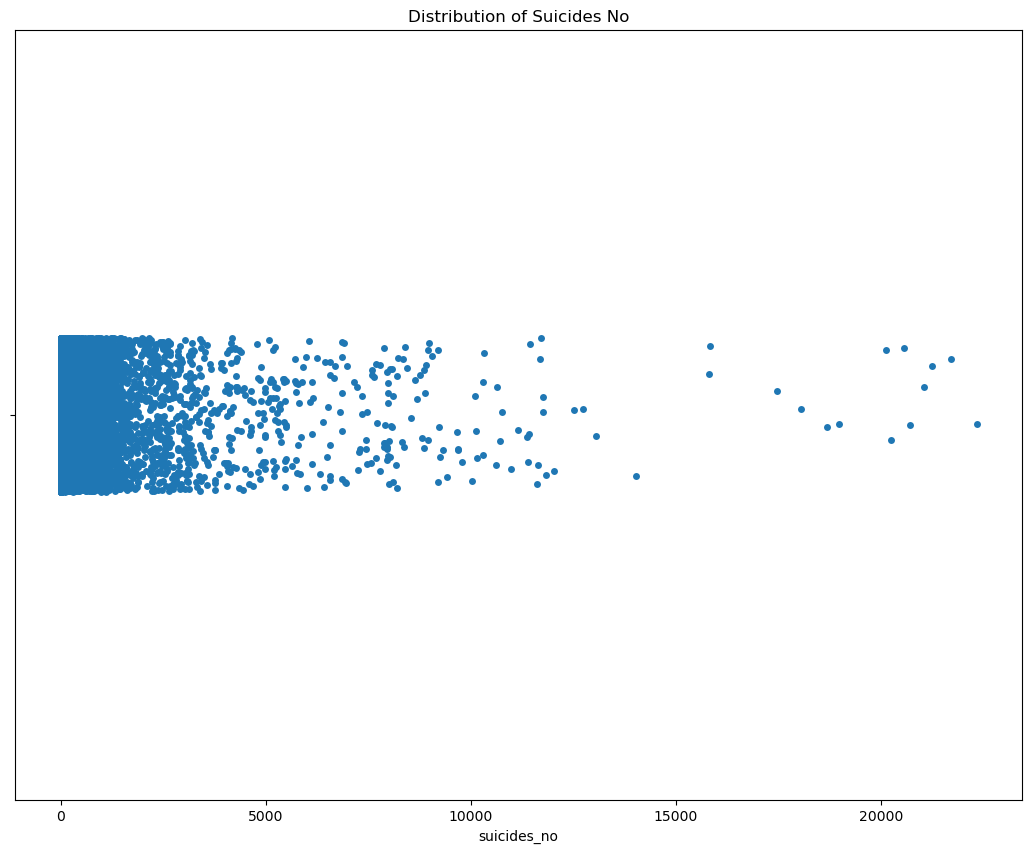

In [18]:
plt.figure(figsize = (13,10))
sns.stripplot(x = 'suicides_no',data = df)
plt.title("Distribution of Suicides No")

Text(0.5, 1.0, 'Distribution of Population')

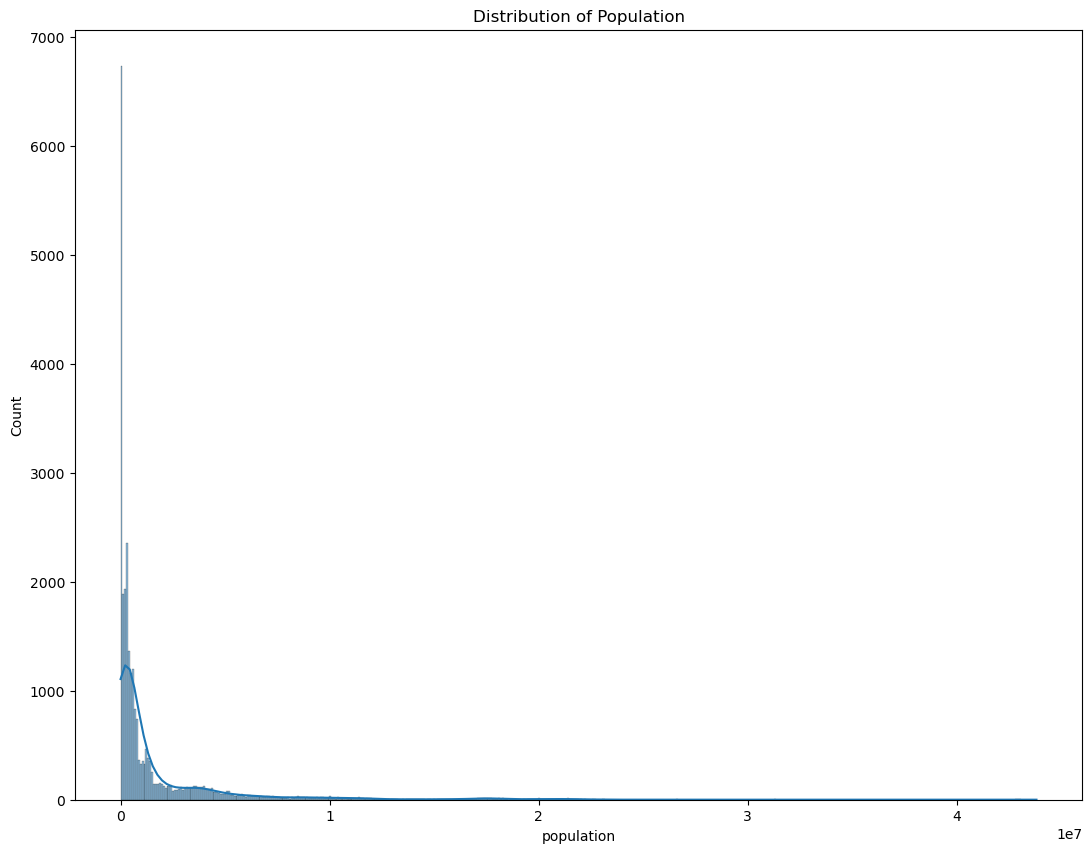

In [19]:
plt.figure(figsize = (13,10))
sns.histplot(df['population'], kde = True)
plt.title("Distribution of Population")

Text(0.5, 1.0, 'Distribution of Population')

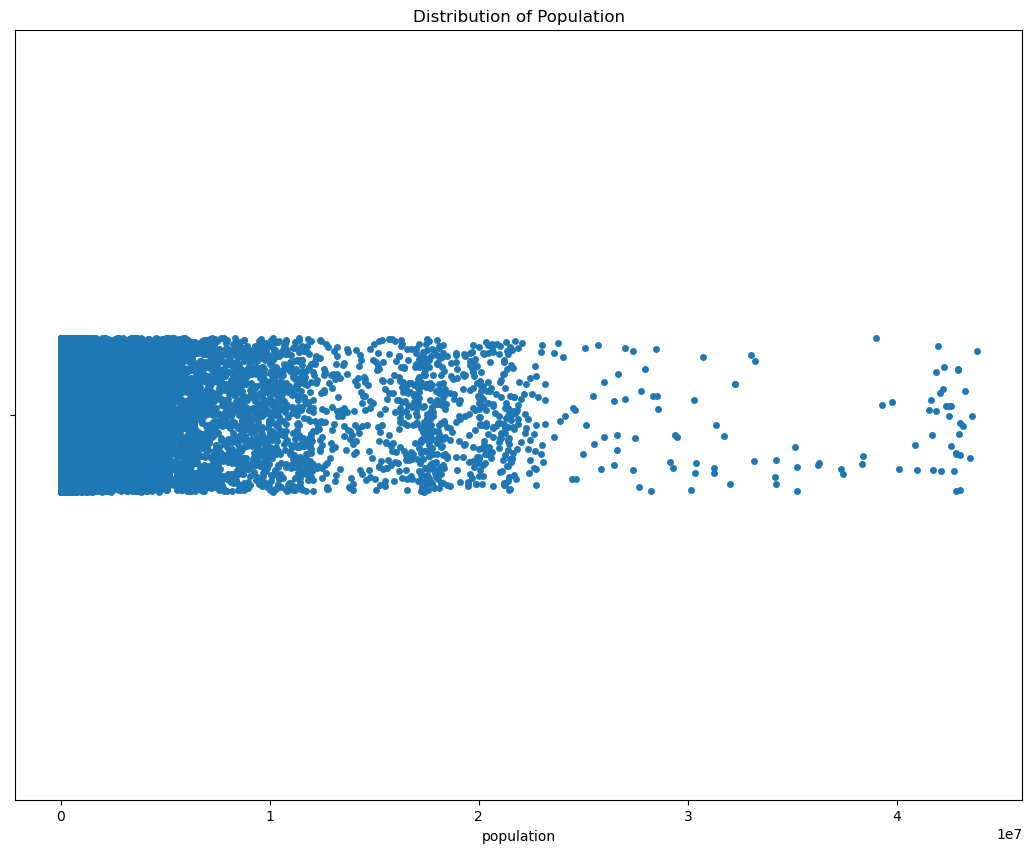

In [20]:
plt.figure(figsize = (13,10))
sns.stripplot(x = 'population',data = df)
plt.title("Distribution of Population")

Text(0.5, 1.0, 'Distribution of GDP for Year)$)')

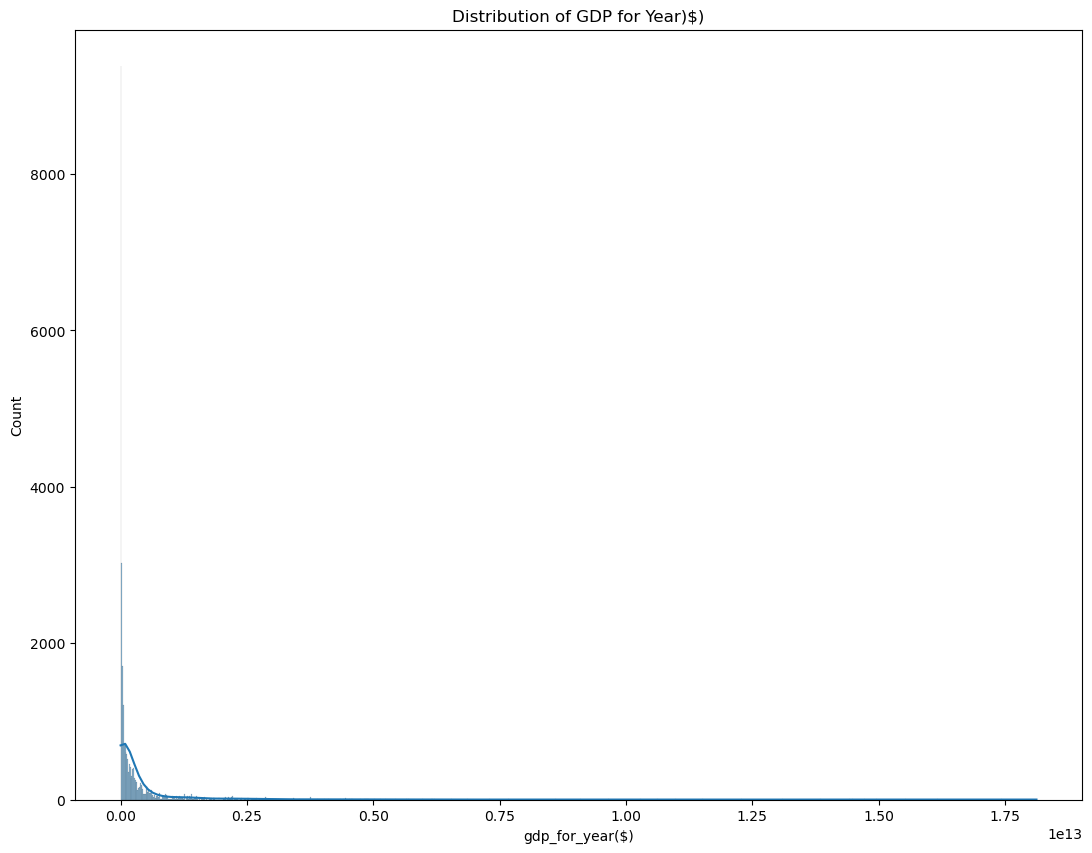

In [21]:
plt.figure(figsize = (13,10))
sns.histplot(df['gdp_for_year($)'], kde = True)
plt.title("Distribution of GDP for Year)$)")

Text(0.5, 1.0, 'Distribution of GDP for Year)$)')

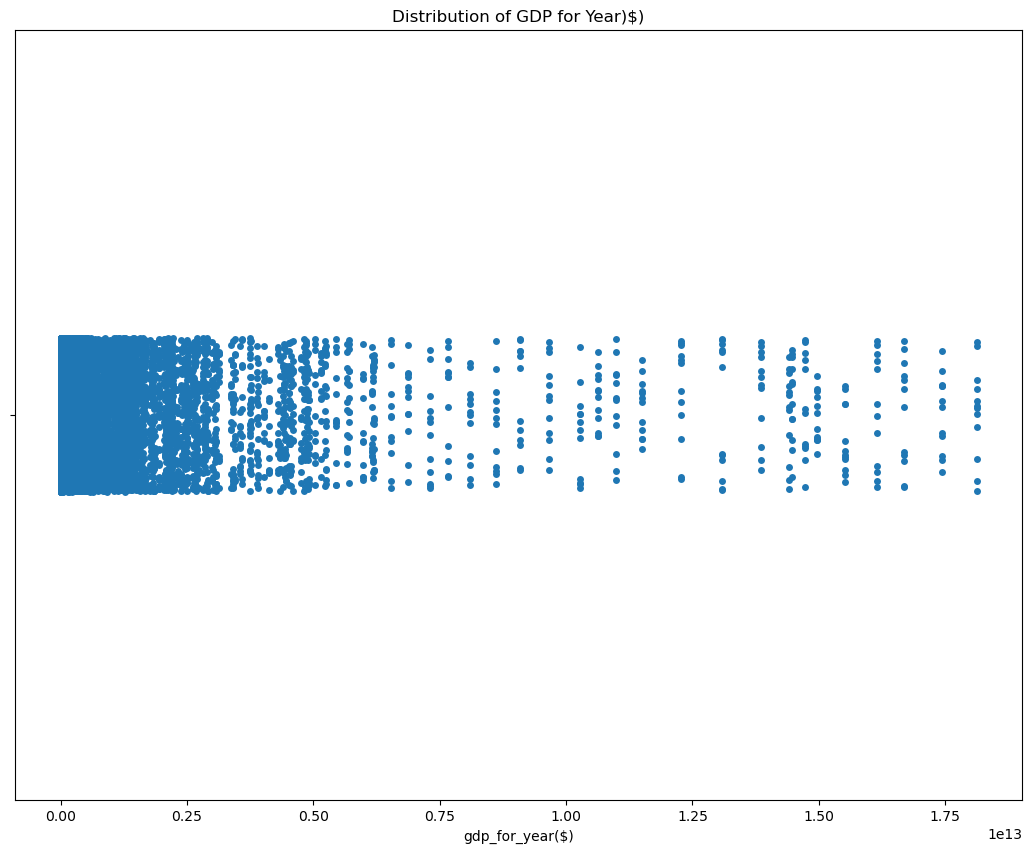

In [22]:
plt.figure(figsize = (13,10))
sns.stripplot(x = 'gdp_for_year($)',data = df)
plt.title("Distribution of GDP for Year)$)")

Text(0.5, 1.0, 'Distribution of Year')

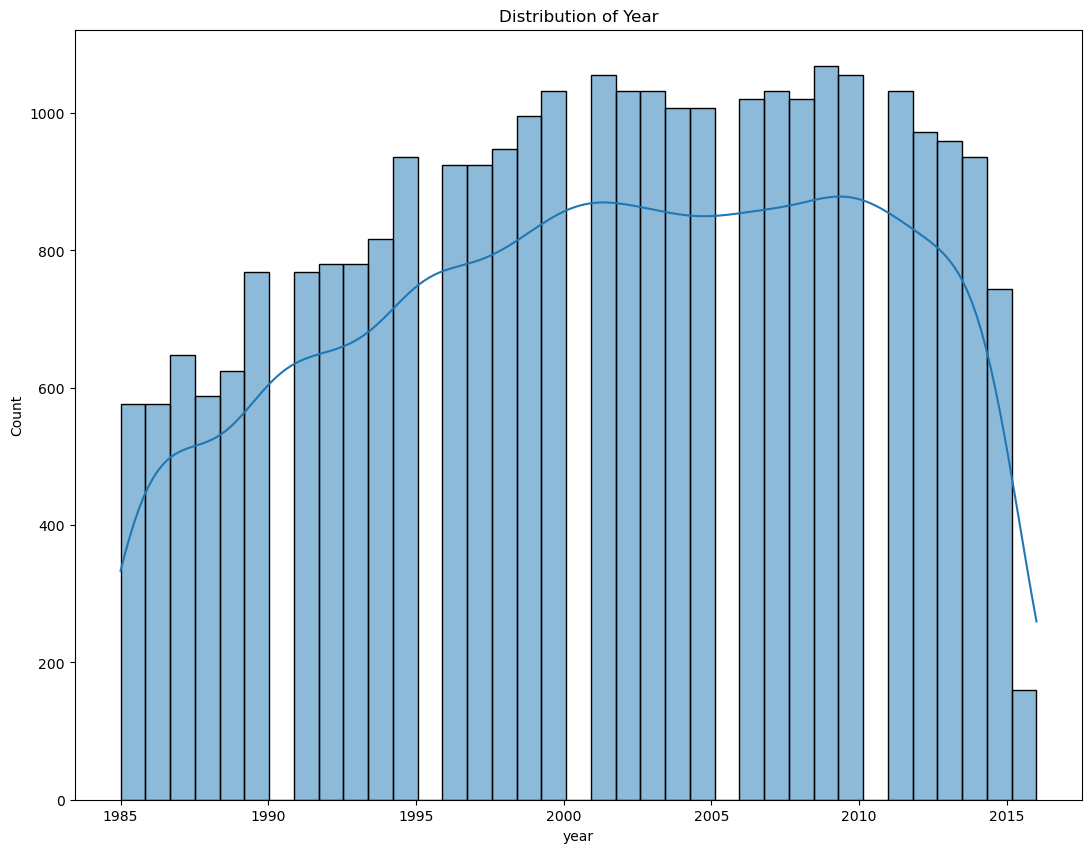

In [23]:
plt.figure(figsize = (13,10))
sns.histplot(df['year'], kde = True)
plt.title("Distribution of Year")

Text(0.5, 1.0, 'Distribution of GDP per Capita')

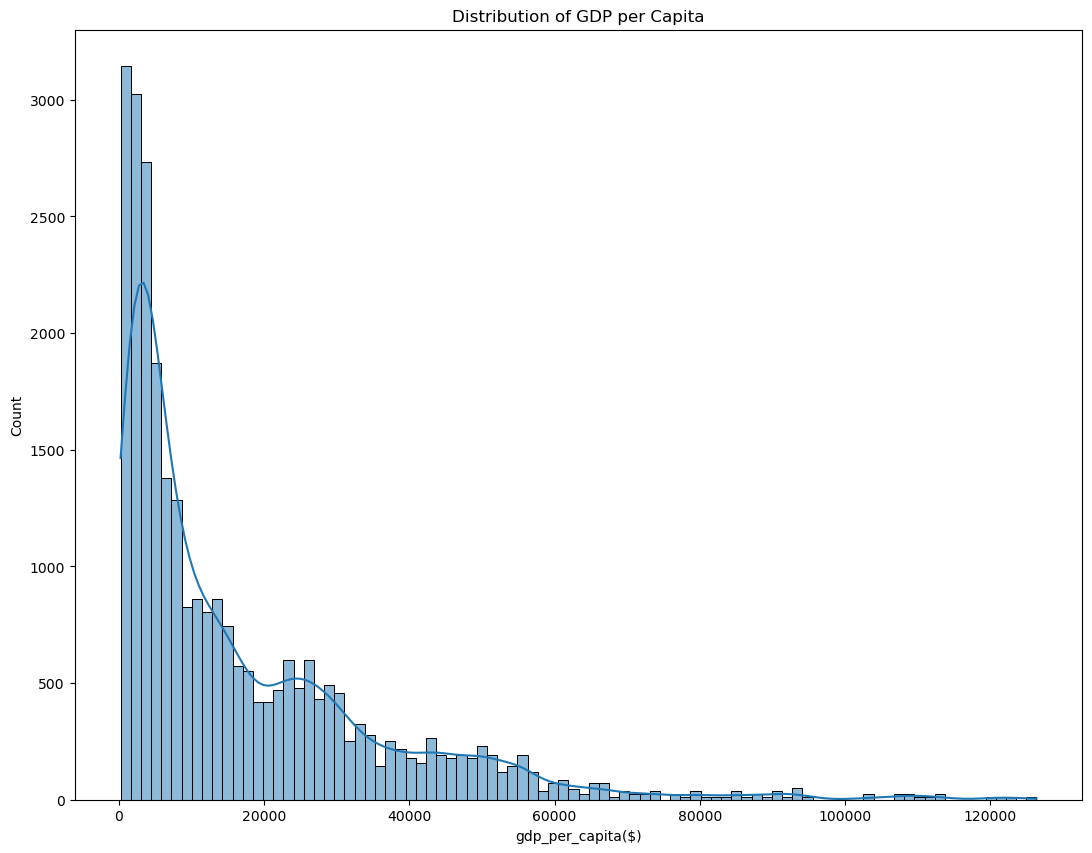

In [24]:
plt.figure(figsize = (13,10))
sns.histplot(df['gdp_per_capita($)'], kde=True)
plt.title("Distribution of GDP per Capita")

Text(0.5, 1.0, 'Distribution of GDP per Capita')

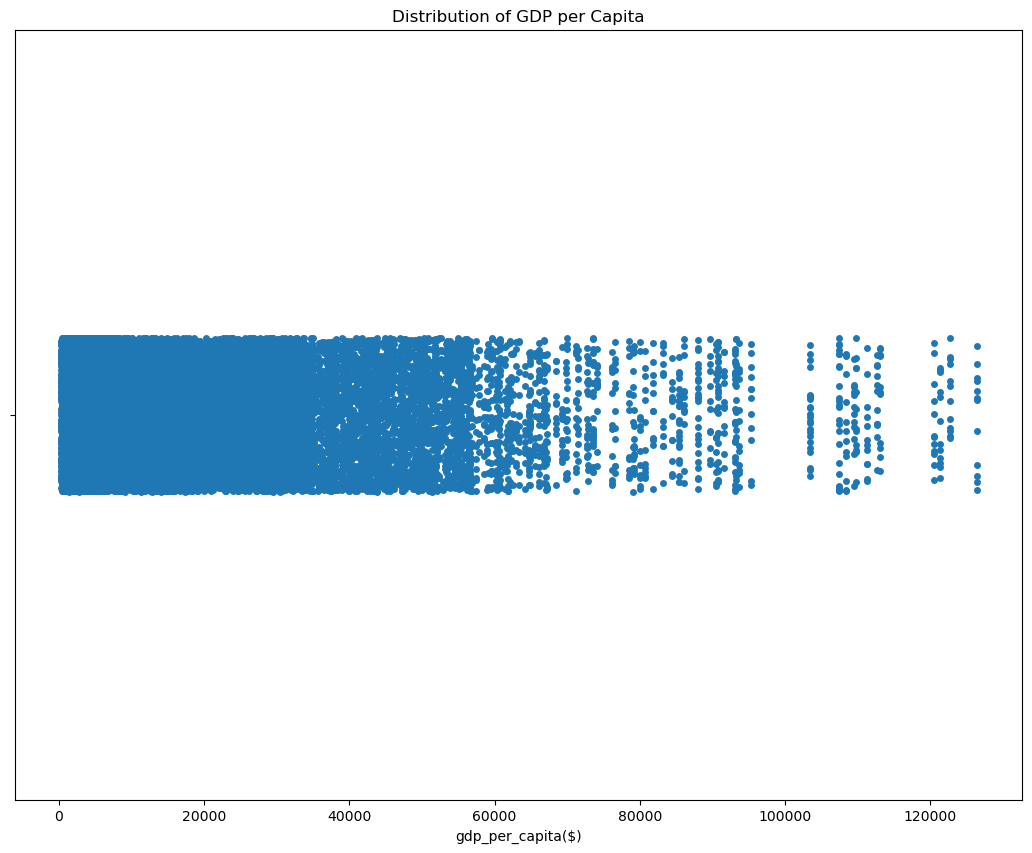

In [25]:
plt.figure(figsize = (13,10))
sns.stripplot(x = 'gdp_per_capita($)',data = df)
plt.title("Distribution of GDP per Capita")

### Univariate Analysis for Categorical Attributes

Text(0.5, 1.0, 'Gender Distribution')

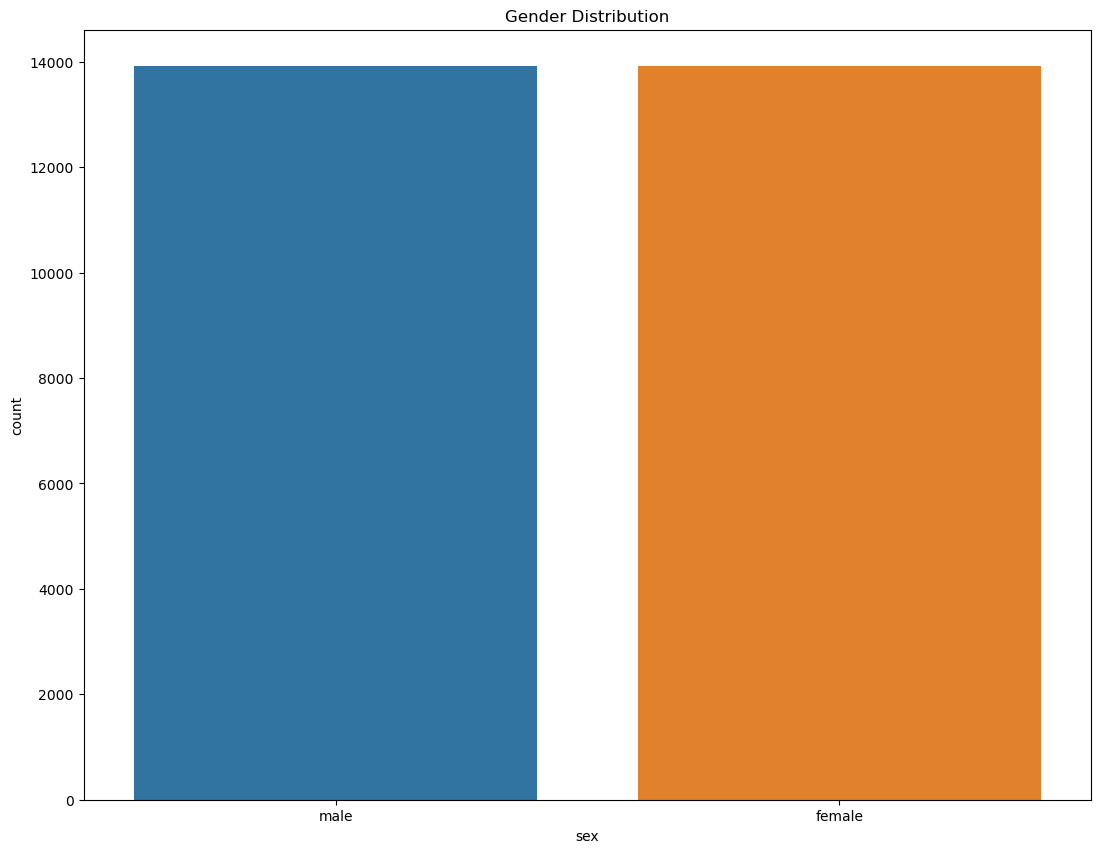

In [26]:
plt.figure(figsize = (13,10))
sns.countplot(x = 'sex', data = df )
plt.title("Gender Distribution")

Text(0.5, 1.0, 'Age Distribution')

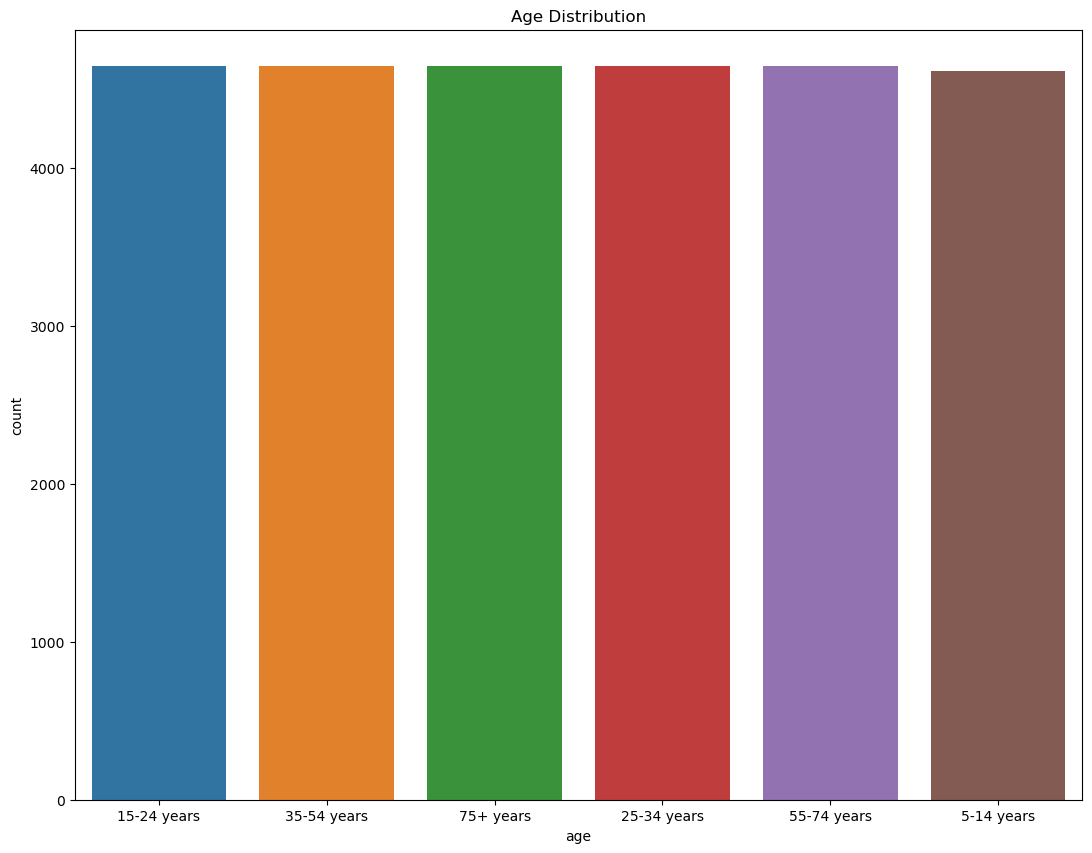

In [27]:
plt.figure(figsize = (13,10))
sns.countplot(x = 'age', data = df )
plt.title("Age Distribution")

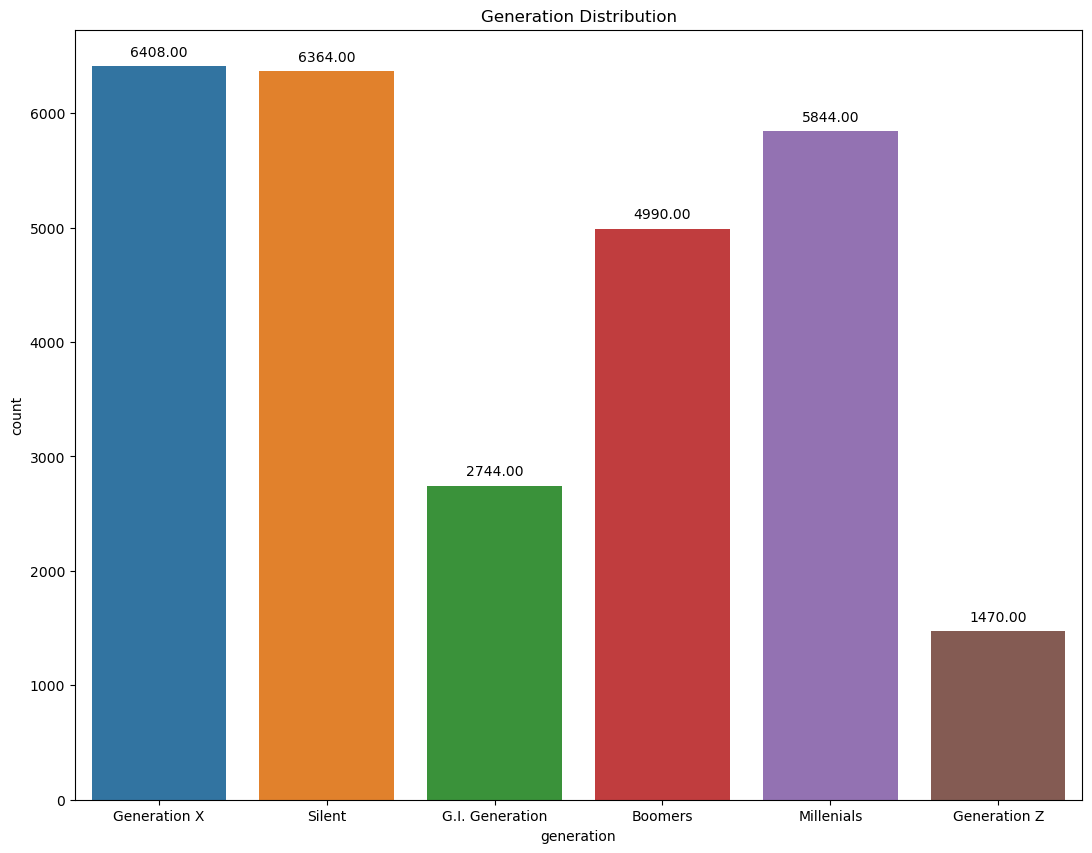

In [28]:
plt.figure(figsize = (13,10))
g = sns.countplot(x = 'generation', data = df )
ax = g
plt.title("Generation Distribution")

#Annoted axix
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

### Univariate Analysis Result

1. Suicide No: In this survey, the attribute Suicide No distribution is extreme right skewed. Most of the observations are between 0 to 1000. Occurance of datapoint more than 5000 is quite rare.

2. Population: In this survey, Population distribution is extremely right skewed.

3. GDP for Year: In this dataset, GDP for Year distribution is also right skewed. Also, most of the datapoints lies between (0.00le13 - 0.60le13).

4. GDP per Capita: GDP per Capita distribution is right skewed and most of the datapoints lies between 0 - 60000.

5. Sex: In this survey, number of male and female are equal.

6. Age: In this survey, every age group has almost equal number of datapoints.

7. Generation: In this survey, most of the datapoints are in Generation X and Silent followed by Millenials, Boomers, C.I. Generation, Generation Z.


### Bivariate Analysis

In [29]:
df_suirate = df.groupby(["country"])["suicides/100k pop"].median()
df_total = df_suirate.copy().reset_index()
df_dict = dict(zip(list(df_total['country']),list(df_total['suicides/100k pop'])))
sorted_dict = dict(sorted(df_dict.items(), key=lambda item: item[1],reverse = True))

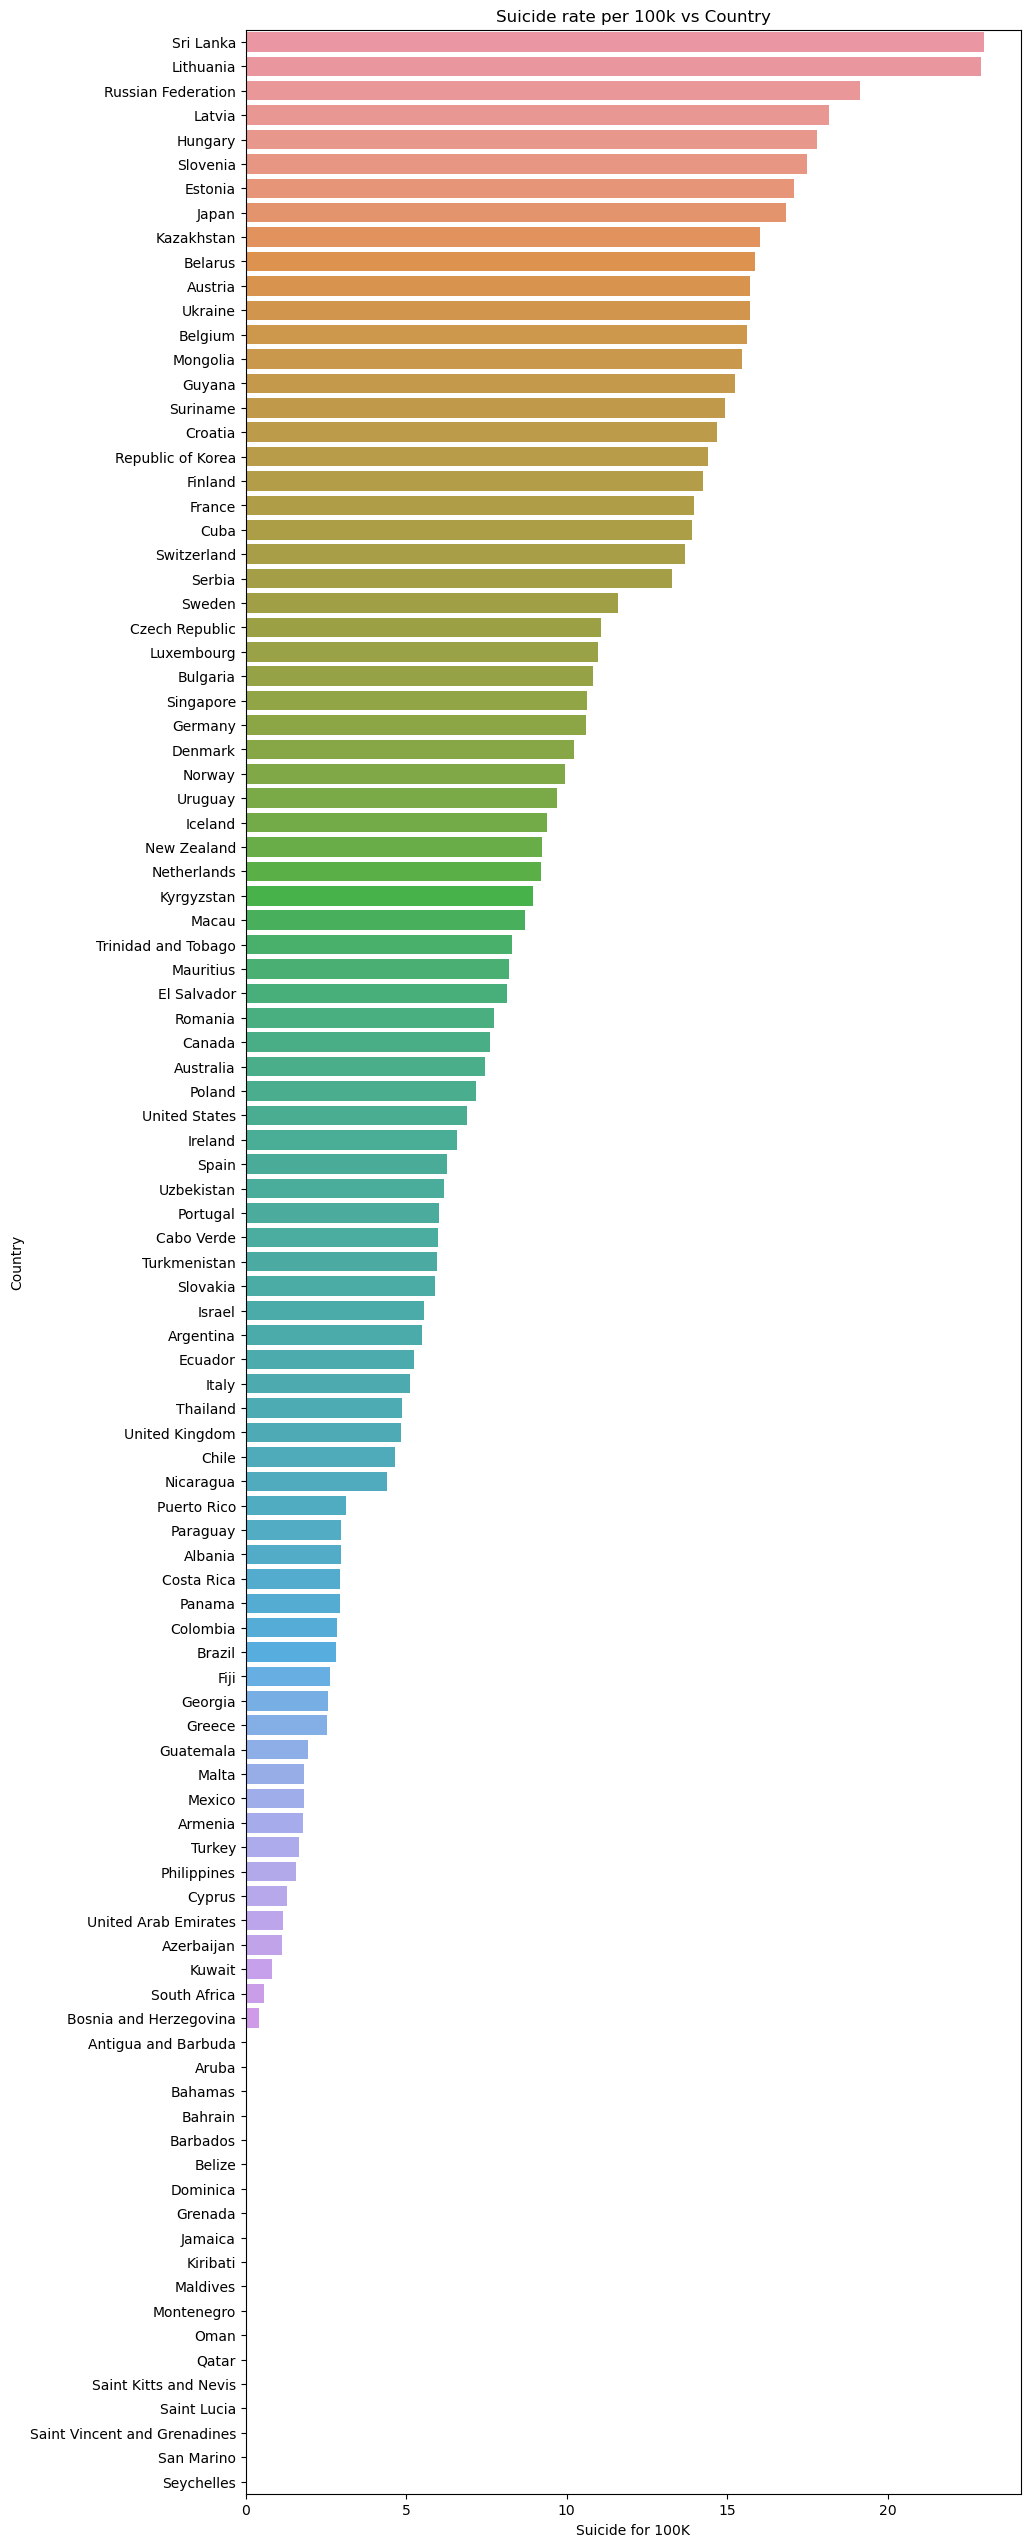

In [30]:
plt.figure(figsize=(10,32))
sns.barplot(x=list(sorted_dict.values()),y=list(sorted_dict.keys()))
plt.xlabel("Suicide for 100K")
plt.ylabel("Country")
plt.title("Suicide rate per 100k vs Country")
plt.show()

Text(0.5, 1.0, 'Year vs GDP Per Capita')

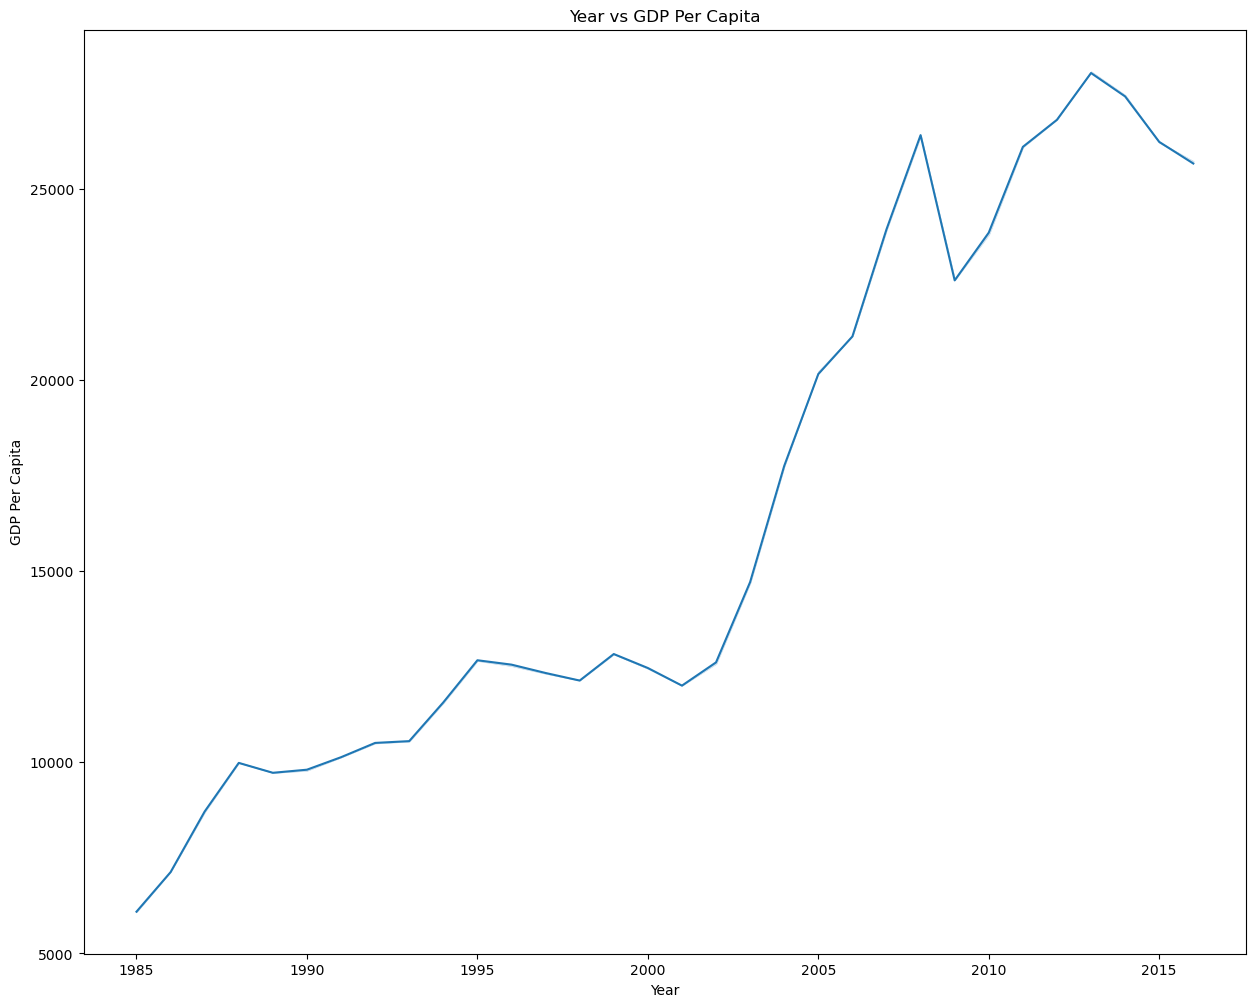

In [31]:
plt.figure(figsize = (15,12))
sns.lineplot(data =df, x = 'year',y='gdp_per_capita($)',errorbar=('ci', False))
plt.xlabel("Year")
plt.ylabel("GDP Per Capita")
plt.title("Year vs GDP Per Capita")

Text(0.5, 1.0, 'Year vs Suicide per 100k')

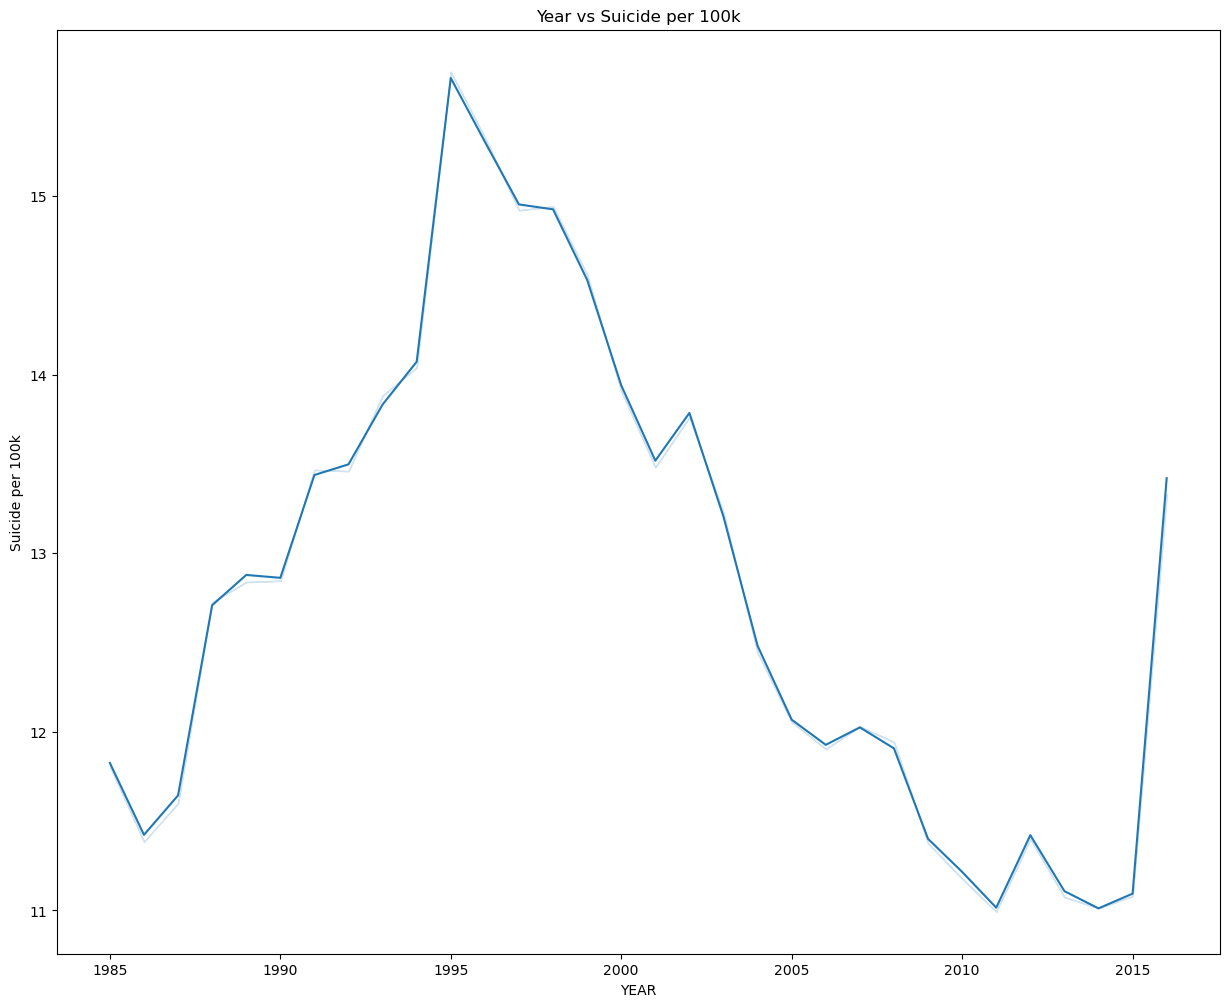

In [32]:
plt.figure(figsize = (15,12))
sns.lineplot(data =df, x = 'year',y='suicides/100k pop',errorbar=('ci', False))
plt.xlabel("YEAR")
plt.ylabel("Suicide per 100k")
plt.title("Year vs Suicide per 100k")

Text(0.5, 1.0, 'GDP Per Capita vs Suicide per 100k Scatterplot')

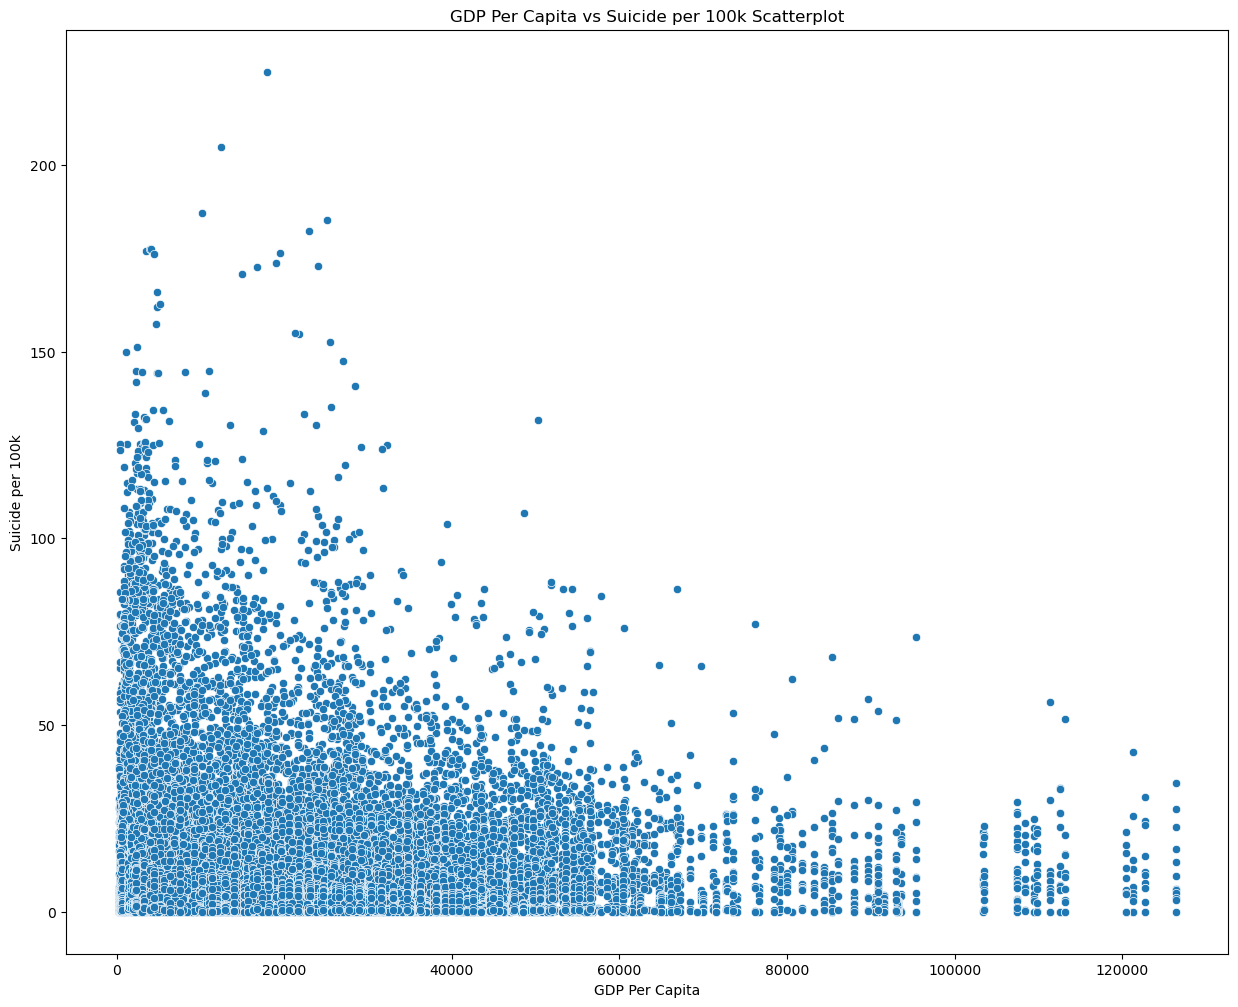

In [33]:
plt.figure(figsize = (15,12))
sns.scatterplot(data =df, x = 'gdp_per_capita($)',y='suicides/100k pop')
plt.xlabel("GDP Per Capita")
plt.ylabel("Suicide per 100k")
plt.title("GDP Per Capita vs Suicide per 100k Scatterplot")

Text(0.5, 1.0, 'GDP Per Capita vs Suicide per 100k Lineplot')

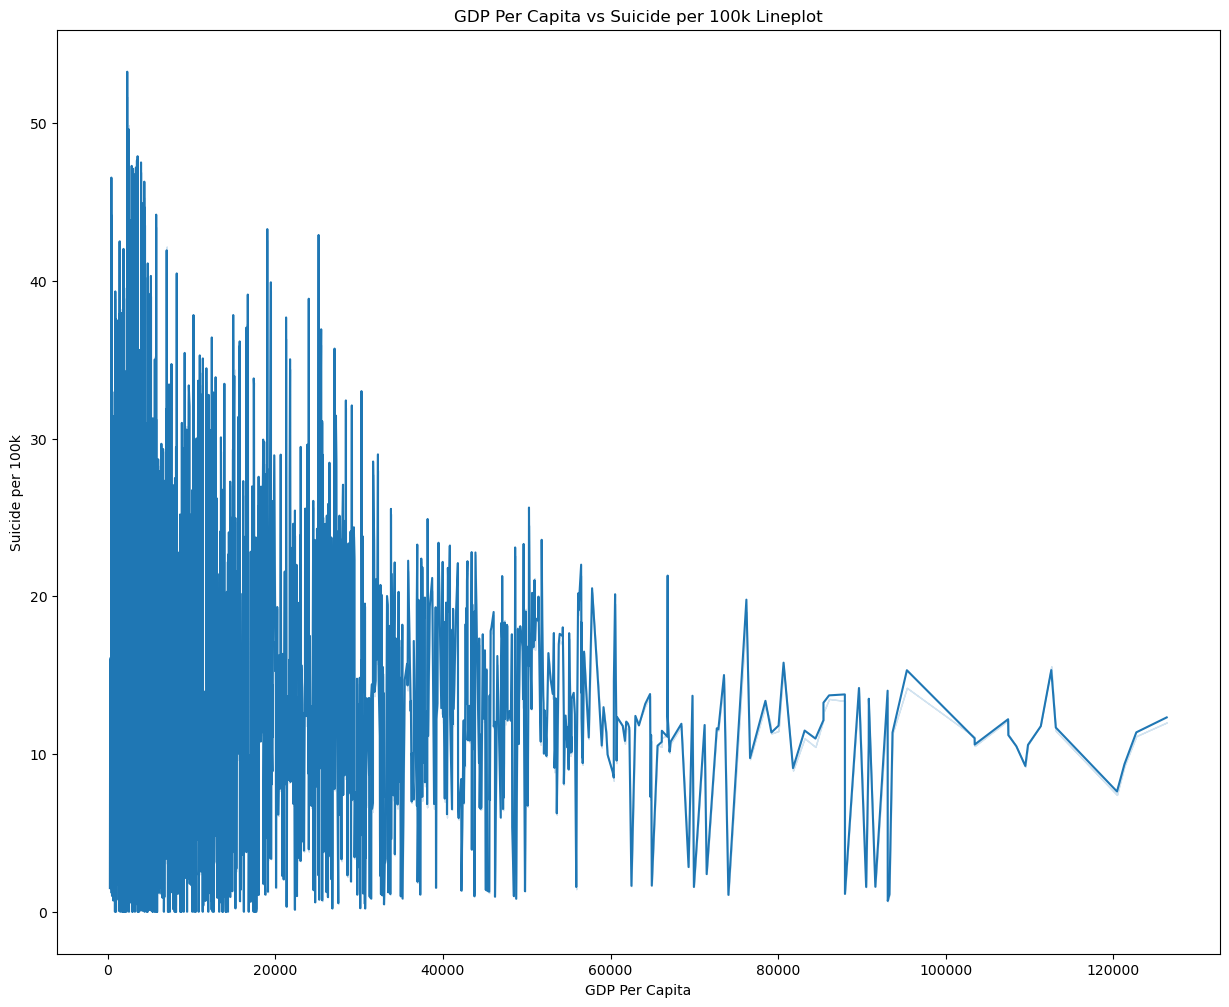

In [34]:
plt.figure(figsize = (15,12))
sns.lineplot(data =df, x = 'gdp_per_capita($)',y='suicides/100k pop',errorbar=('ci', False))
plt.xlabel("GDP Per Capita")
plt.ylabel("Suicide per 100k")
plt.title("GDP Per Capita vs Suicide per 100k Lineplot")

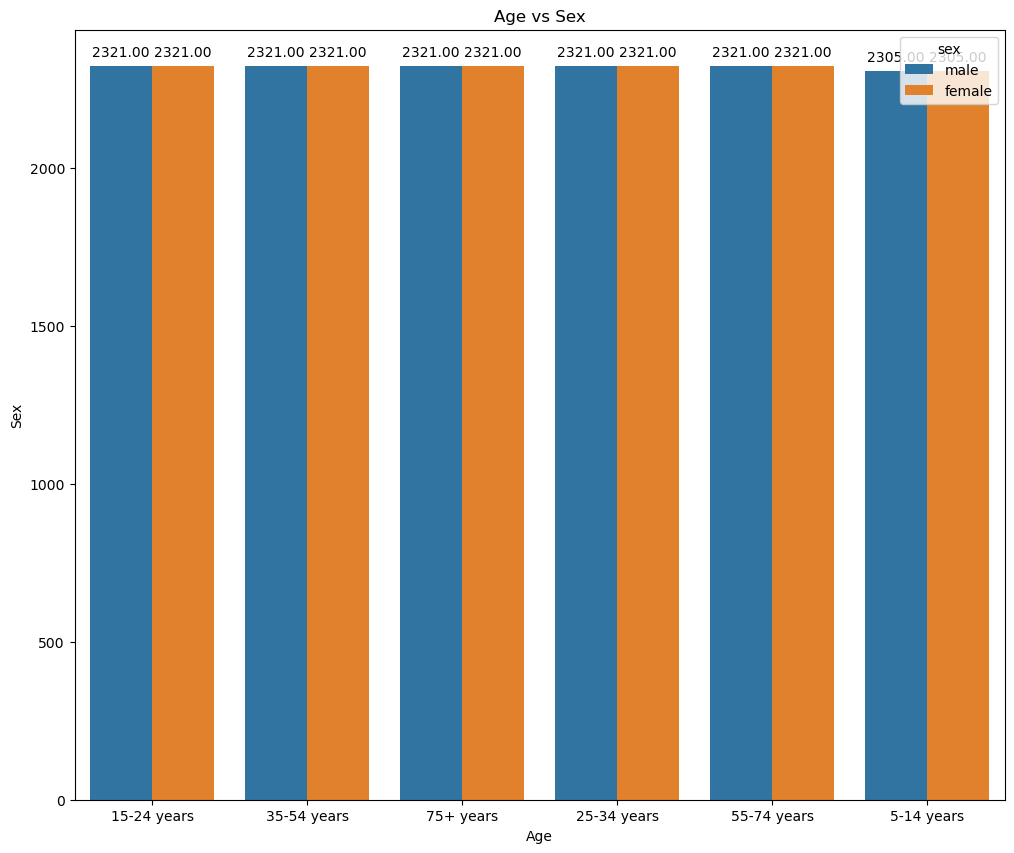

In [35]:
plt.figure(figsize = (12,10))
g = sns.countplot(data = df, x = 'age',hue = 'sex')
ax = g
plt.xlabel("Age")
plt.ylabel("Sex")
plt.title("Age vs Sex")

#Annoted axix
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Text(0.5, 1.0, 'Year vs Genderwise Sucide per 100K')

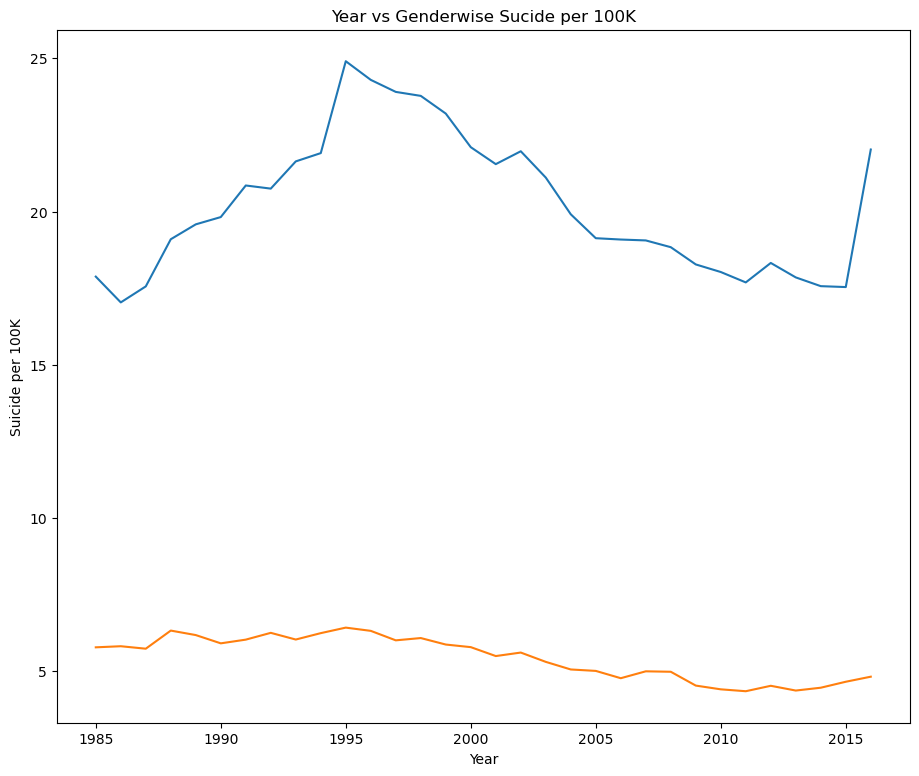

In [40]:
## Splitting male and female attributes
df_men = df[df['sex'] == 'male']
df_women = df[df['sex'] == 'female']

#plotting them into lineplot
plt.figure(figsize = (11,9))
sns.lineplot(data = df_men, x= 'year',y='suicides/100k pop', errorbar=None)
sns.lineplot(data = df_women, x= 'year',y='suicides/100k pop',errorbar=None)
#plt.legend(["male","female"])
plt.xlabel("Year")
plt.ylabel("Suicide per 100K")
plt.title("Year vs Genderwise Sucide per 100K")

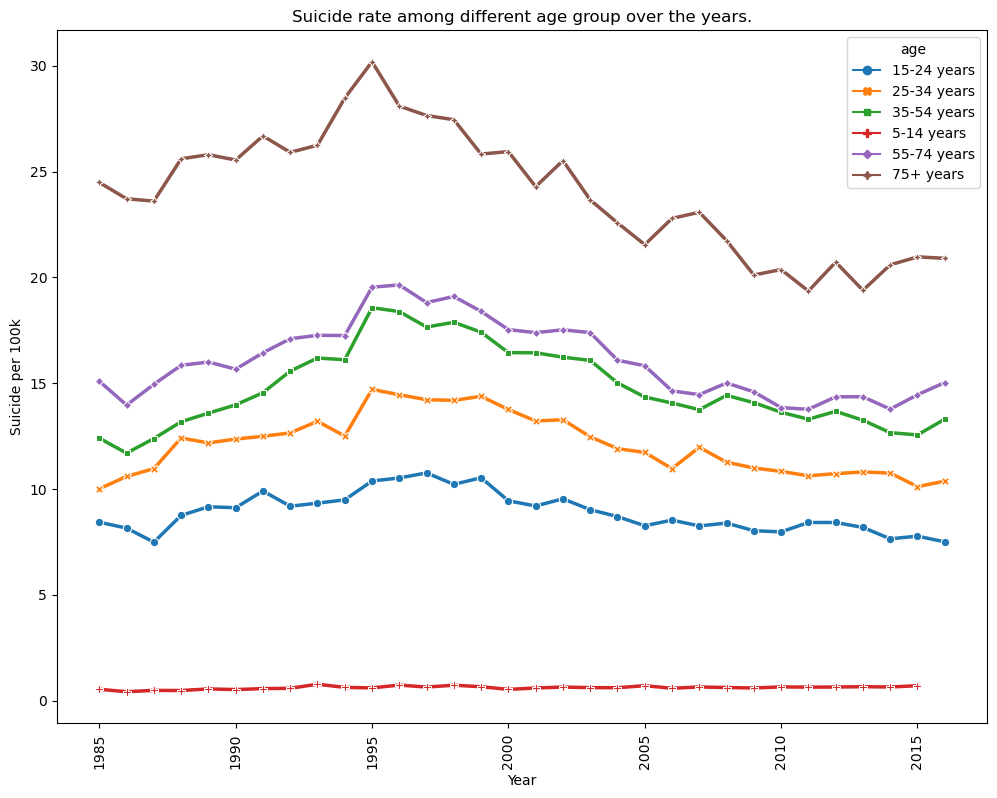

In [37]:
df_age = df.groupby(["year","age"])["suicides/100k pop"].mean()
df_reset = df_age.copy().reset_index()
plt.figure(figsize=(12,9))
sns.lineplot(x = "year", y= "suicides/100k pop", hue = "age",
             data = df_reset, linewidth = 2.5, style = "age", markers=True
            , dashes=False)
plt.xticks(rotation = 90)

plt.xlabel('Year')
plt.ylabel("Suicide per 100k")
plt.title("Suicide rate among different age group over the years.")
plt.show()

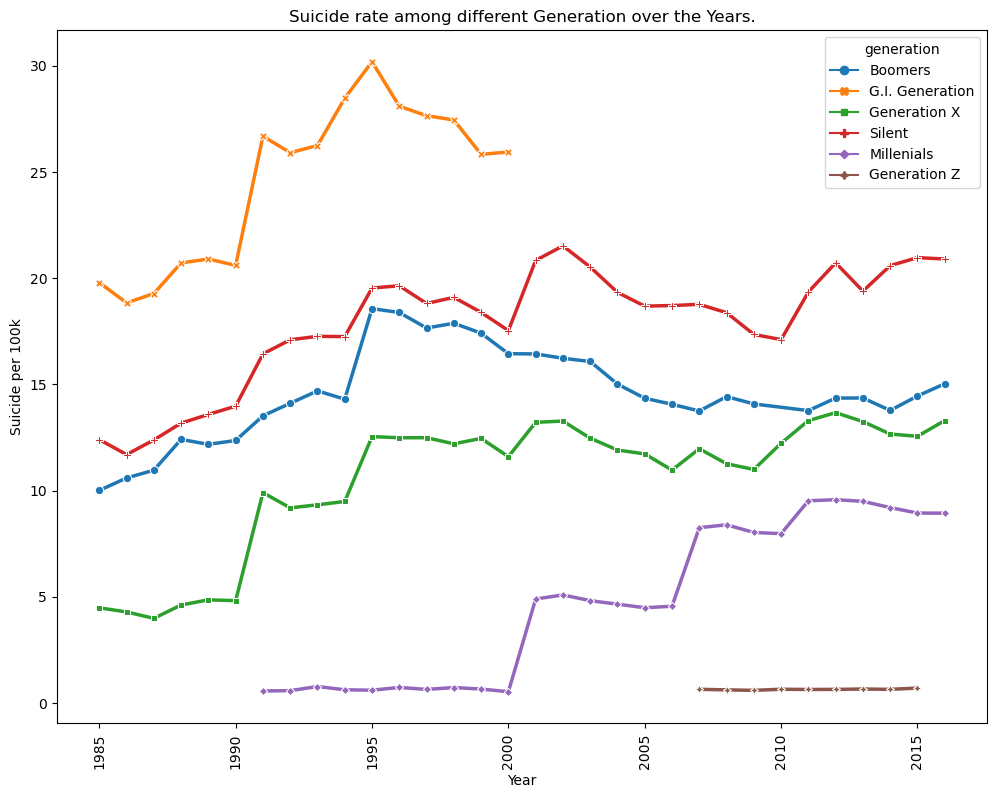

In [38]:
df_age = df.groupby(["year","generation"])["suicides/100k pop"].mean()
df_reset = df_age.copy().reset_index()
plt.figure(figsize=(12,9))
sns.lineplot(x = "year", y = "suicides/100k pop", hue = "generation",
             data = df_reset, linewidth = 2.5, style = "generation", markers=True
            , dashes=False)
plt.xticks(rotation = 90)
plt.xlabel('Year')
plt.ylabel("Suicide per 100k")
plt.title("Suicide rate among different Generation over the Years.")
plt.show()

Text(0.5, 1.0, 'GDP per Capita vs Suicide per 100k over Age,Sex and Generation')

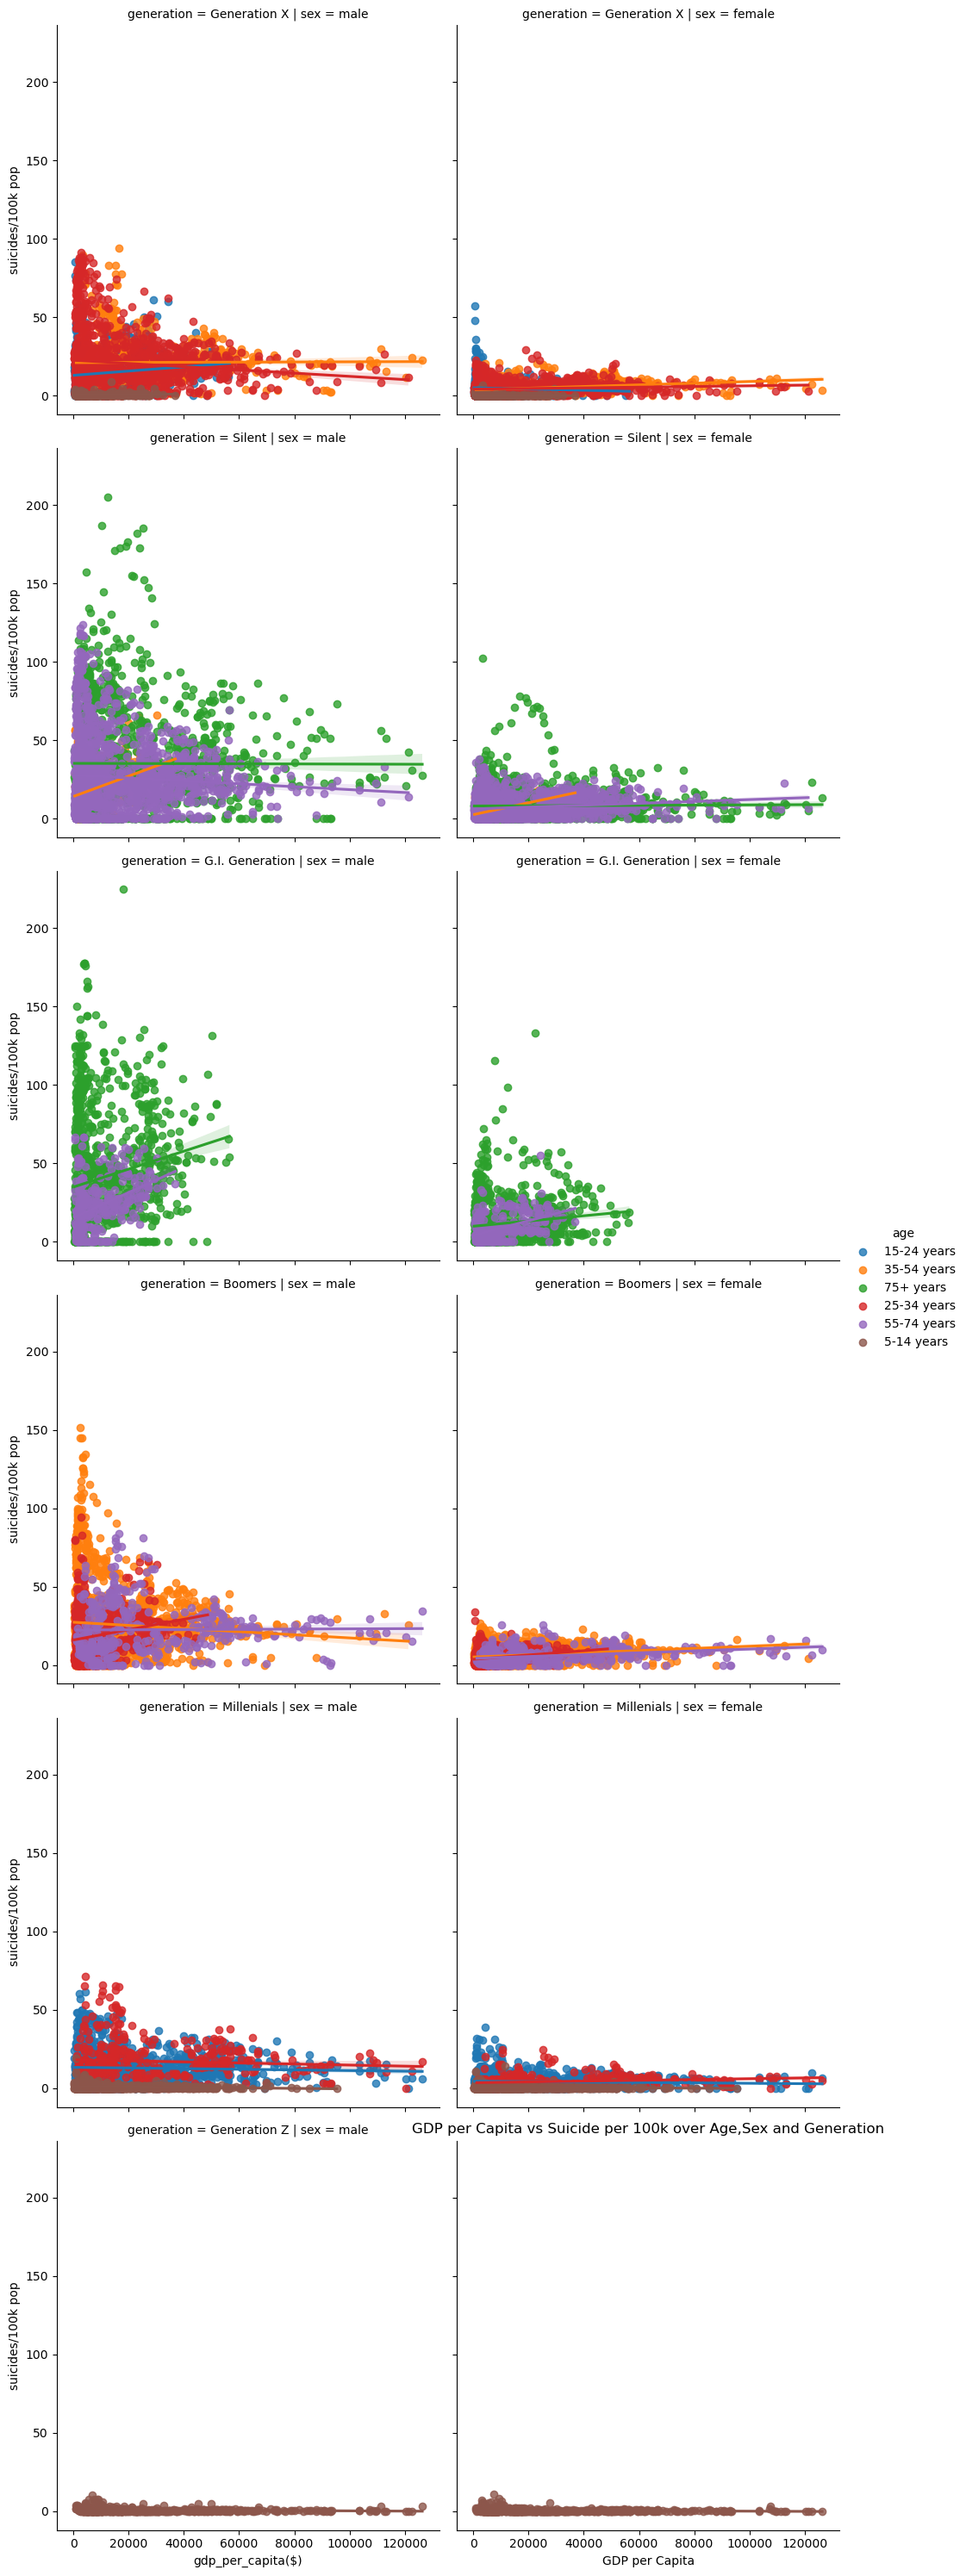

In [43]:
#sysBP vs diaBP with respect to currentSmoker and male
sns.lmplot(x='gdp_per_capita($)',y='suicides/100k pop',data = df,hue = 'age',col = 'sex',row = 'generation')
plt.xlabel("GDP per Capita")
plt.ylabel("Suicide per 100k")
plt.title("GDP per Capita vs Suicide per 100k over Age,Sex and Generation")

### Bivariate Analysis

1 . Country vs Suicide Rate per 100k: In this given data we can find Srilanka and Lithunia has highest suicide rate over the years among all the countries also Seychelles and San Mario has median 0 suicide rate over the years. Most of the country having suicide rate between 2-16.

2. Year vs GDP per Capita: In this survey, it is observed that, GDP per capita is significantly increased for all the country over the years.

3. Year vs Suicide per 100k Pop: In this dataset, initially Suicide rate had started increasing from year 1985 and reached the peak in the year 1995 then it started decreasing gradually. Also, it is observed a hike in suicide rate from the year 2015 again.

4. Age vs Sex: The total number of male and female, being suicide victim are almost same for every age group.

5. Year vs Genderwise Sucide per 100K: In this survey, we can see male suicide rate is quite higher than female suicide rate over the years.

6. Suicide rate among different age group over the years.: In the year 1995, we can notice peak in suicide rate in every age group excluding 5-14 and 15-24 years age groups. Also it is observed, with growing age people are tend to commit more suicide.

7. Suicide rate among different Generation over the Years.: In this survey, Generation GI has commited more suicide than anyother generation also Generation Z has least number of suicide commited.

8. GDP per Capita vs Suicide per 100k over Age,Sex and Generation: No such significat evidence found in GDP per capita and suicde per 100k in each graph but it has seen that,
a. Generation Z mostly contains 5-14 years age groups.
b. Generation Millenial mostly contains 15-24 and 25-34 years age group.
c. Generation Boomer mostly contains 35-54 years age group it also contains 25-34 years age group and 55-74 years age group.
d. Generation GI mostly contains 75+ years of age group some of them are in 55-74 years age group.
e. In Generation silent most of them are 55-74years age group and some of them are 75+ years.
f. Generation X mostly contains 25-34 years age group.`

### Outlier Removal

(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, 'year'),
  Text(2, 0, 'suicides_no'),
  Text(3, 0, 'population'),
  Text(4, 0, 'suicides/100k pop'),
  Text(5, 0, 'gdp_for_year($)'),
  Text(6, 0, 'gdp_per_capita($)')])

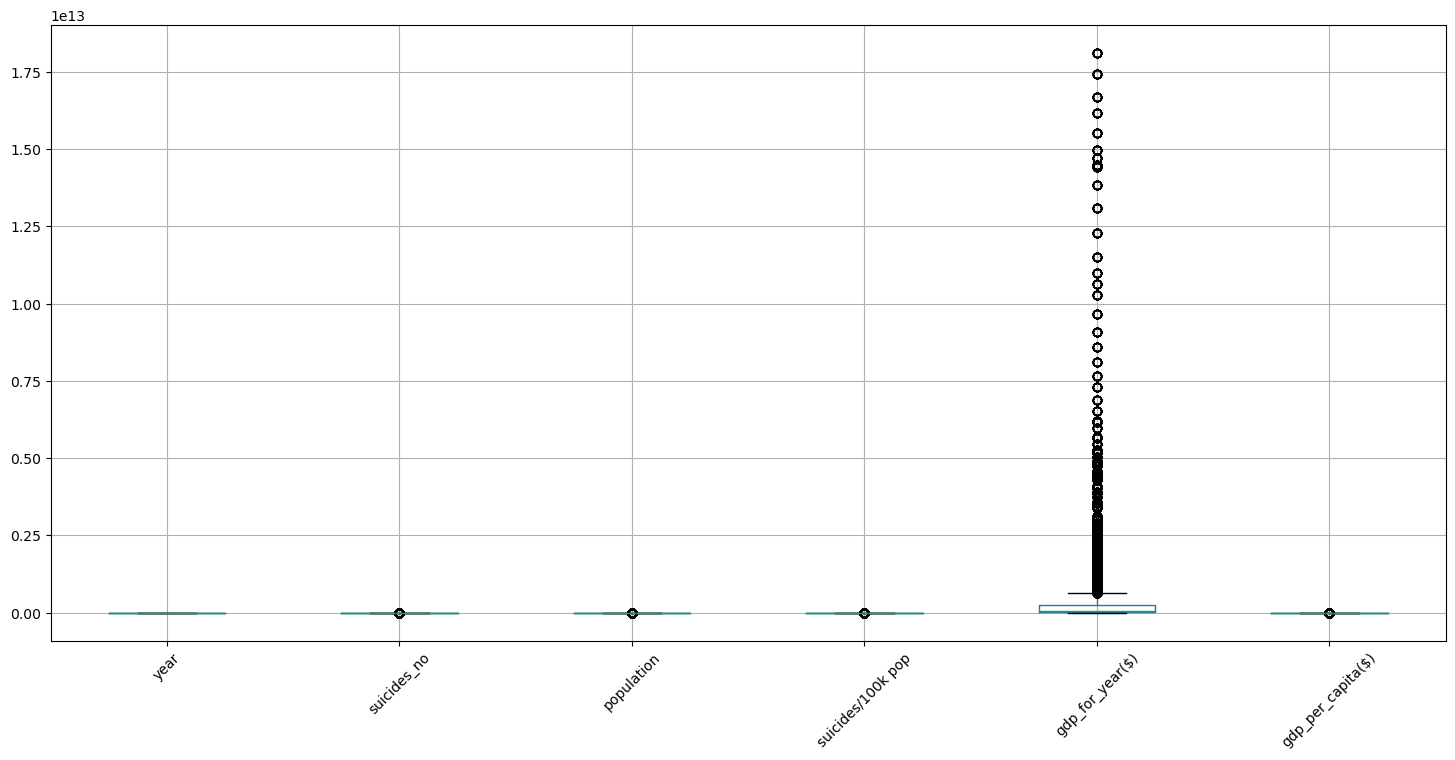

In [44]:
# Checking for outlier by using Boxplot
plt.figure(figsize = (18,8))
df.boxplot()
plt.xticks(rotation = 45)

In [45]:
# Calculate uper and lower limit to detect outliers
def remove_outlier(col):
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [46]:
num = df.select_dtypes(['float64','int64'])
cat = df.select_dtypes(['object'])

for i in num.columns:
    ll,ul=remove_outlier(df[i])
    df[i]=np.where(df[i]>ul,ul,df[i])
    df[i]=np.where(df[i]<ll,ll,df[i])

(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, 'year'),
  Text(2, 0, 'suicides_no'),
  Text(3, 0, 'population'),
  Text(4, 0, 'suicides/100k pop'),
  Text(5, 0, 'gdp_for_year($)'),
  Text(6, 0, 'gdp_per_capita($)')])

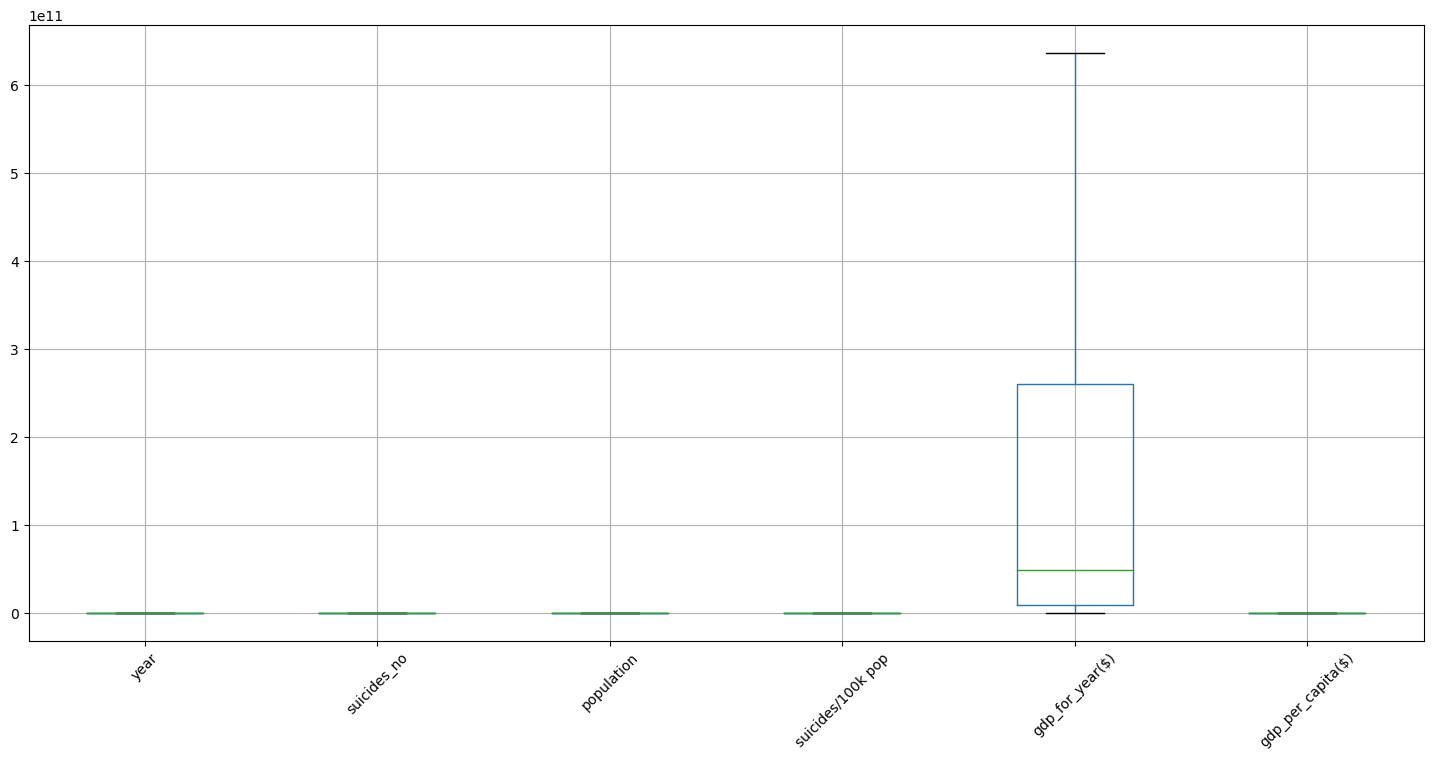

In [47]:
# Checking for outlier by using Boxplot
plt.figure(figsize = (18,8))
df.boxplot()
plt.xticks(rotation = 45)

### Encoding Categorical Columns

In [48]:
# Encoding Sex Column
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_for_year($),gdp_per_capita($),generation
0,Albania,1987.0,1,15-24 years,21.0,312900.000,6.71,2.156625e+09,796.0,Generation X
1,Albania,1987.0,1,35-54 years,16.0,308000.000,5.19,2.156625e+09,796.0,Silent
2,Albania,1987.0,0,15-24 years,14.0,289700.000,4.83,2.156625e+09,796.0,Generation X
3,Albania,1987.0,1,75+ years,1.0,21800.000,4.59,2.156625e+09,796.0,G.I. Generation
4,Albania,1987.0,1,25-34 years,9.0,274300.000,3.28,2.156625e+09,796.0,Boomers
...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014.0,0,35-54 years,107.0,3569110.375,2.96,6.306708e+10,2309.0,Generation X
27816,Uzbekistan,2014.0,0,75+ years,9.0,348465.000,2.58,6.306708e+10,2309.0,Silent
27817,Uzbekistan,2014.0,1,5-14 years,60.0,2762158.000,2.17,6.306708e+10,2309.0,Generation Z
27818,Uzbekistan,2014.0,0,5-14 years,44.0,2631600.000,1.67,6.306708e+10,2309.0,Generation Z


In [49]:
#Encoding age and generation column
oe = OrdinalEncoder(cols = ['age','generation'],return_df = True,mapping = [{'col': 'age', 'mapping': {'5-14 years':0,'15-24 years':1,'25-34 years':2,'35-54 years':3,'55-74 years':4,'75+ years':5}}, 
{'col': 'generation', 'mapping': {'Generation Z':0,'Millenials':1,'Generation X':2,'Boomers':3,'Silent':4,'G.I. Generation':5}}])
df = oe.fit_transform(df)
df

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_for_year($),gdp_per_capita($),generation
0,Albania,1987.0,1,1,21.0,312900.000,6.71,2.156625e+09,796.0,2
1,Albania,1987.0,1,3,16.0,308000.000,5.19,2.156625e+09,796.0,4
2,Albania,1987.0,0,1,14.0,289700.000,4.83,2.156625e+09,796.0,2
3,Albania,1987.0,1,5,1.0,21800.000,4.59,2.156625e+09,796.0,5
4,Albania,1987.0,1,2,9.0,274300.000,3.28,2.156625e+09,796.0,3
...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014.0,0,3,107.0,3569110.375,2.96,6.306708e+10,2309.0,2
27816,Uzbekistan,2014.0,0,5,9.0,348465.000,2.58,6.306708e+10,2309.0,4
27817,Uzbekistan,2014.0,1,0,60.0,2762158.000,2.17,6.306708e+10,2309.0,0
27818,Uzbekistan,2014.0,0,0,44.0,2631600.000,1.67,6.306708e+10,2309.0,0


In [50]:
independent_df = df.drop('suicides/100k pop', axis=1)
y = df[['suicides/100k pop']]

In [51]:
target_enc = TargetEncoder(cols = ['country','year'])
df = target_enc.fit_transform(independent_df,y)
df

,country,year,sex,age,suicides_no,population,gdp_for_year($),gdp_per_capita($),generation
0,3.502879,10.325154,1,1,21.0,312900.000,2.156625e+09,796.0,2
1,3.502879,10.325154,1,3,16.0,308000.000,2.156625e+09,796.0,4
2,3.502879,10.325154,0,1,14.0,289700.000,2.156625e+09,796.0,2
3,3.502879,10.325154,1,5,1.0,21800.000,2.156625e+09,796.0,5
4,3.502879,10.325154,1,2,9.0,274300.000,2.156625e+09,796.0,3
...,...,...,...,...,...,...,...,...,...
27815,8.099129,9.989348,0,3,107.0,3569110.375,6.306708e+10,2309.0,2
27816,8.099129,9.989348,0,5,9.0,348465.000,6.306708e+10,2309.0,4
27817,8.099129,9.989348,1,0,60.0,2762158.000,6.306708e+10,2309.0,0
27818,8.099129,9.989348,0,0,44.0,2631600.000,6.306708e+10,2309.0,0


In [52]:
encoded_df = pd.concat([df,y],axis = 1)
encoded_df

,country,year,sex,age,suicides_no,population,gdp_for_year($),gdp_per_capita($),generation,suicides/100k pop
0,3.502879,10.325154,1,1,21.0,312900.000,2.156625e+09,796.0,2,6.71
1,3.502879,10.325154,1,3,16.0,308000.000,2.156625e+09,796.0,4,5.19
2,3.502879,10.325154,0,1,14.0,289700.000,2.156625e+09,796.0,2,4.83
3,3.502879,10.325154,1,5,1.0,21800.000,2.156625e+09,796.0,5,4.59
4,3.502879,10.325154,1,2,9.0,274300.000,2.156625e+09,796.0,3,3.28
...,...,...,...,...,...,...,...,...,...,...
27815,8.099129,9.989348,0,3,107.0,3569110.375,6.306708e+10,2309.0,2,2.96
27816,8.099129,9.989348,0,5,9.0,348465.000,6.306708e+10,2309.0,4,2.58
27817,8.099129,9.989348,1,0,60.0,2762158.000,6.306708e+10,2309.0,0,2.17
27818,8.099129,9.989348,0,0,44.0,2631600.000,6.306708e+10,2309.0,0,1.67


In [53]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            27820 non-null  float64
 1   year               27820 non-null  float64
 2   sex                27820 non-null  int32  
 3   age                27820 non-null  int32  
 4   suicides_no        27820 non-null  float64
 5   population         27820 non-null  float64
 6   gdp_for_year($)    27820 non-null  float64
 7   gdp_per_capita($)  27820 non-null  float64
 8   generation         27820 non-null  int32  
 9   suicides/100k pop  27820 non-null  float64
dtypes: float64(7), int32(3)
memory usage: 1.8 MB


In [54]:
#Encoding country and year column
#one_enc = OneHotEncoder(cols = ['country','year'])
#df = one_enc.fit_transform(df)
#df

### Scaling the dataset using Standard Scaler

In [55]:
st_scale = StandardScaler()
scaled_df = st_scale.fit_transform(encoded_df)
scaled_df = pd.DataFrame(scaled_df, columns = encoded_df.columns)
scaled_df

,country,year,sex,age,suicides_no,population,gdp_for_year($),gdp_per_capita($),generation,suicides/100k pop
0,-1.195500,-0.659975,1.0,-0.880574,-0.570082,-0.581239,-0.752781,-0.944026,-0.433847,-0.335742
1,-1.195500,-0.659975,1.0,0.291278,-0.613285,-0.585069,-0.752781,-0.944026,0.972378,-0.458324
2,-1.195500,-0.659975,-1.0,-0.880574,-0.630565,-0.599373,-0.752781,-0.944026,-0.433847,-0.487357
3,-1.195500,-0.659975,1.0,1.463130,-0.742891,-0.808772,-0.752781,-0.944026,1.675491,-0.506712
4,-1.195500,-0.659975,1.0,-0.294648,-0.673768,-0.611410,-0.752781,-0.944026,0.269265,-0.612359
...,...,...,...,...,...,...,...,...,...,...
27815,-0.450905,-1.064400,-1.0,0.291278,0.172997,1.963918,-0.480657,-0.850482,-0.433847,-0.638165
27816,-0.450905,-1.064400,-1.0,1.463130,-0.673768,-0.553440,-0.480657,-0.850482,0.972378,-0.668811
27817,-0.450905,-1.064400,1.0,-1.466500,-0.233105,1.333178,-0.480657,-0.850482,-1.840073,-0.701876
27818,-0.450905,-1.064400,-1.0,-1.466500,-0.371352,1.231130,-0.480657,-0.850482,-1.840073,-0.742199


In [56]:
df_pca = scaled_df

In [57]:
#df_pca = encoded_df.apply(zscore)
#df_pca

In [58]:
df_pca['age'].value_counts()

-0.880574    4642
 0.291278    4642
 1.463130    4642
-0.294648    4642
 0.877204    4642
-1.466500    4610
Name: age, dtype: int64

In [59]:
independent_df = df_pca.drop('suicides/100k pop', axis=1)
y = df_pca[['suicides/100k pop']]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(independent_df, y, test_size=0.30 , random_state=1)

In [61]:
X_train

,country,year,sex,age,suicides_no,population,gdp_for_year($),gdp_per_capita($),generation
5473,-0.056768,0.455534,-1.0,0.291278,0.121154,0.780823,-0.450860,-0.692392,0.269265
3737,1.245733,-1.093679,-1.0,-0.880574,-0.457756,-0.320680,1.402376,1.951561,-1.136960
17600,0.556725,1.345548,-1.0,1.463130,-0.708330,-0.735376,-0.467221,0.184000,1.675491
25259,-0.616999,-0.914931,-1.0,0.877204,1.166649,1.963918,1.013718,-0.586174,0.269265
27529,0.784856,-1.138234,-1.0,-0.880574,-0.621925,-0.625788,-0.505389,0.130706,-1.136960
...,...,...,...,...,...,...,...,...,...
10955,-1.246951,-0.879375,1.0,-1.466500,-0.716970,0.604705,-0.627355,-0.829214,-1.136960
17289,-0.041912,0.033466,1.0,-0.880574,-0.163981,-0.055553,1.792446,1.332306,-1.136960
5192,0.256787,-0.716907,1.0,0.291278,2.039334,1.963918,2.083576,2.038798,0.269265
12172,-0.016185,1.074724,-1.0,-0.294648,-0.673768,-0.625635,-0.507021,0.069436,0.269265


In [62]:
X_test

,country,year,sex,age,suicides_no,population,gdp_for_year($),gdp_per_capita($),generation
1599,0.339456,1.178937,-1.0,-0.294648,0.259401,0.302795,0.972781,0.367934,-0.433847
25048,-0.616999,0.903459,1.0,-1.466500,-0.656487,1.963918,-0.264489,-0.862168,-1.136960
26902,0.398741,0.593549,-1.0,0.877204,2.039334,1.963918,2.083576,0.531033,1.675491
10722,-1.246951,-0.659975,-1.0,-0.294648,-0.613285,-0.382546,-0.730766,-0.931599,0.269265
9680,-1.077915,-1.138234,-1.0,0.877204,-0.682408,-0.457116,-0.690309,-0.755208,0.269265
...,...,...,...,...,...,...,...,...,...
16752,-1.000351,0.472992,-1.0,1.463130,-0.647846,0.055957,2.083576,-0.505305,1.675491
6515,1.076003,-0.679043,-1.0,1.463130,-0.362711,-0.665893,-0.493943,-0.115055,0.972378
26266,1.456579,0.033466,-1.0,0.877204,2.039334,1.963918,-0.538442,-0.925416,0.972378
11782,0.248581,1.074724,-1.0,1.463130,-0.734251,-0.820105,-0.734294,0.610356,1.675491


In [63]:
y_train

,suicides/100k pop
5473,-0.480905
3737,-0.452679
17600,-0.528487
25259,-0.529293
27529,-0.404292
...,...
10955,-0.859136
17289,-0.320420
5192,1.094114
12172,-0.593810


In [64]:
y_test

,suicides/100k pop
1599,-0.223644
25048,-0.861555
26902,-0.338968
10722,-0.649456
9680,-0.739780
...,...
16752,-0.791393
6515,0.896531
26266,0.169103
11782,1.332827


In [73]:
Y = y.copy()
Y = np.ravel(Y)

### Now we are going to take Cross Validation Score of our Single Models. Models we are going to use for this classification problem:

#### 1. Linear Regression

#### 2. Lasso Regression

#### 3. Ridge Regression

#### 4. K-Nearest Neighbour Regression

#### 5. Support Vector Machine Regression

#### 6. Decision Tree Regression

#### 7. Random Forest Regression

#### 8. Gradient Boosting Regression

#### 9. XGBoost Regression

#### 10. Light Gradient Boosting Regression

#### 11. Stacking Regression

In [85]:
LR = LinearRegression()
KNNR = KNeighborsRegressor()
SVMR = SVR(kernel = 'rbf')
DTR = DecisionTreeRegressor()
RFR = RandomForestRegressor()
XGBR = XGBRegressor()
LGBMR = LGBMRegressor()

In [97]:
#We need a dictionary to store the model name and their accuracy using KFold Cross validation
accuracy = dict()

In [98]:
#Linear Regression
accuracy['Linear Regression']=cross_val_score(LinearRegression(),independent_df, Y,cv =5 ).mean() * 100

#Lasso Regression
accuracy['Lasso Regression']=cross_val_score(Lasso(alpha=0.01),independent_df, Y,cv =5 ).mean() * 100

#Ridge Regression
accuracy['Ridge Regression']=cross_val_score(Ridge(alpha=1),independent_df, Y,cv =5 ).mean() * 100

#K-Nearest Neighbor Regression
accuracy['KNN Regression'] = cross_val_score(KNeighborsRegressor(n_neighbors=8),independent_df, Y,cv =5 ).mean() * 100

#Support Vector Machine Regression
accuracy['Support Vector Machine Regression'] = cross_val_score(SVR(kernel='rbf'),independent_df, Y,cv =5 ).mean() * 100

#Decision Tree Regression
accuracy['Decision Tree Regression'] = cross_val_score(DecisionTreeRegressor(),independent_df, Y,cv =5 ).mean() * 100

#Random Forest Regression
accuracy['Random Forest Regression'] = cross_val_score(RandomForestRegressor(),independent_df, Y,cv =5 ).mean() * 100

#XGBoost Regression
accuracy['XGBoost Regression'] = cross_val_score(XGBRegressor(),independent_df, Y,cv =5 ).mean() * 100

#LGBM Regressor
accuracy['LGBM Regression'] = cross_val_score(LGBMRegressor(n_estimators=2000),independent_df, Y,cv =5 ).mean() * 100

#Stacking Regressor
accuracy['Stacking Regression'] = cross_val_score(StackingRegressor(regressors=[KNNR,SVMR,RFR],meta_regressor = DTR),independent_df, Y,cv =5 ).mean() * 100

C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.wa

In [99]:
accuracy

{'Linear Regression': 67.29615415240741,
 'Lasso Regression': 67.2846446111476,
 'Ridge Regression': 67.29637492746285,
 'KNN Regression': 76.90617328171366,
 'Support Vector Machine Regression': 85.71059164062112,
 'Decision Tree Regression': 90.60351050879748,
 'Random Forest Regression': 93.86873345054066,
 'XGBoost Regression': 95.76775028202158,
 'LGBM Regression': 96.45189888360835,
 'Stacking Regression': 93.56119976986183}

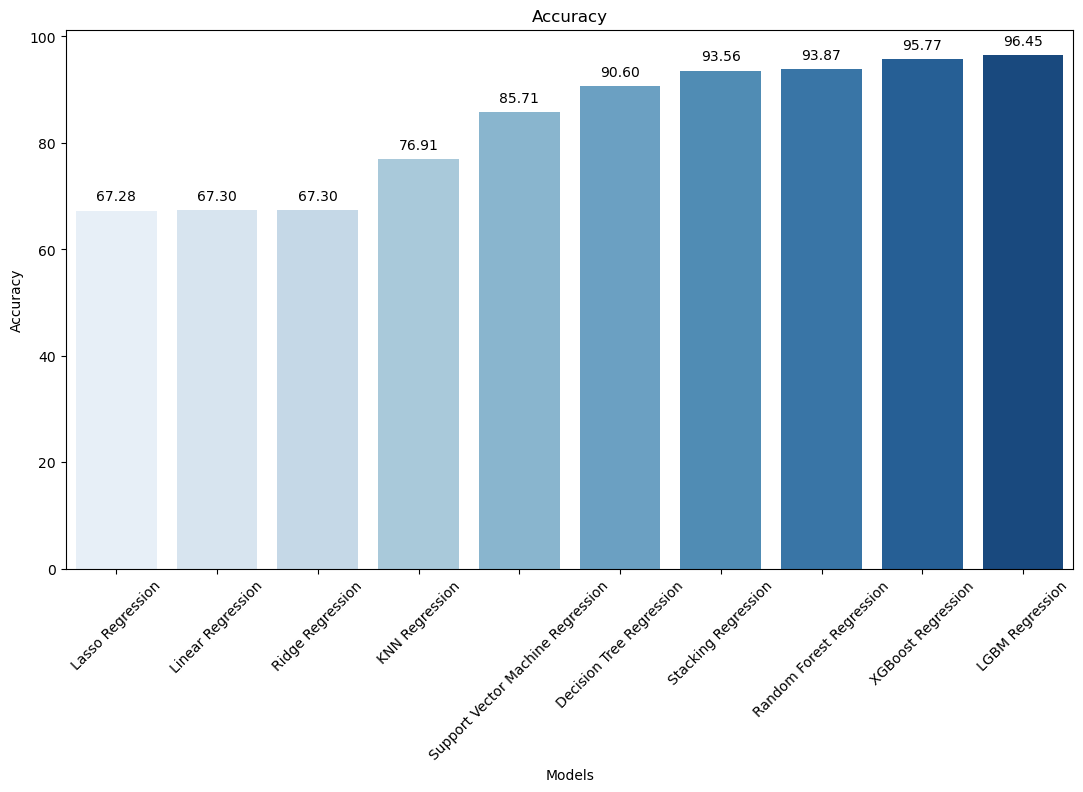

In [107]:
#Our Final Accuracy 
accuracy_not_tuned = {"Models": list(accuracy.keys()),
                     "Accuracy": list(accuracy.values())}
accuracy_not_tuned = pd.DataFrame(accuracy_not_tuned).sort_values(ascending = True, by = 'Accuracy')
accuracy_not_tuned["Type"] = pd.Series(["Single Model" for x in range(len(df.index))])


plt.figure(figsize=(13,7))
g = sns.barplot(x='Models',y = "Accuracy",data = accuracy_not_tuned,palette='Blues')
ax = g
plt.xticks(rotation = 45)
plt.xlabel("Models")
plt.ylabel('Accuracy')
plt.title('Accuracy')

#Annoted axix
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


### Hyperparameter Tuning

#### We are going to take our best 5 models, for hyperparameter tuning.

### Light Gradient Boosting Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)

In [95]:
st = StackingRegressor(regressors=[KNNR,SVMR,RFR],meta_regressor = DTR)

In [96]:
cross_val_score(st,independent_df, Y,cv =5 ).mean() * 100

C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\arghy\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.wa

93.55865544133589

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

In [ ]:
rf.score(X_train, y_train)

In [ ]:
rf.score(X_test, y_test)

In [ ]:
rf_pred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,explained_variance_score,mean_squared_error

In [ ]:
explained_variance_score(y_test,rf_pred)

In [ ]:
np.sqrt(mean_squared_error(y_test,rf_pred))

In [ ]:
from sklearn.svm import SVR

In [ ]:
sv = SVR(kernel = 'rbf')
sv.fit(X_train,y_train)
sv_pred = sv.predict(X_test)

In [ ]:
sv.score(X_train,y_train)

In [ ]:
sv.score(X_test,y_test)

In [ ]:
np.sqrt(mean_squared_error(y_test,sv_pred))

In [ ]:
explained_variance_score(y_test,sv_pred)

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
L1 = Lasso(alpha=0.01)
L1.fit(X_train,y_train)

In [ ]:
L1.score(X_train,y_train)

In [ ]:
L1.score(X_test,y_test)

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
L2 = Ridge(alpha = 1)

In [ ]:
L2.fit(X_train,y_train)

In [ ]:
L2.score(X_train,y_train)

In [ ]:
L2.score(X_test,y_test)

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
L_reg = ElasticNet(alpha = 0.01)
L_reg.fit(X_train,y_train)

In [ ]:
L_reg.score(X_train,y_train)

In [ ]:
L_reg.score(X_test,y_test)

In [ ]:
from xgboost import XGBRegressor

In [ ]:
x_reg = XGBRegressor()
x_reg.fit(X_train,y_train)

In [ ]:
x_reg.score(X_train,y_train)

In [ ]:
x_reg.score(X_test,y_test)

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgt_reg = LGBMRegressor(n_estimators=2000)
lgt_reg.fit(X_train,y_train)

In [ ]:
lgt_reg.score(X_train,y_train)

In [ ]:
lgt_reg.score(X_test,y_test)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
DT_reg = DecisionTreeRegressor()
DT_reg.fit(X_train,y_train)

In [ ]:
DT_reg.score(X_train,y_train)

In [ ]:
DT_reg.score(X_test,y_test)

In [ ]:
knnr = KNeighborsRegressor(n_neighbors=8)
knnr.fit(X_train,y_train)

In [ ]:
knnr.score(X_train,y_train)

In [ ]:
knnr.score(X_test,y_test)